In [4]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [5]:
"""
Created on May 1 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [6]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [7]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

print(Zernike_Module.__version__)
print(Zernike_Analysis_Module.__version__)

0.28e
0.24a


In [15]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.17.0
0.16.2
1.3.1
0.25.1


## unit test 

In [10]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,npix=1536)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28e
npix_value:1536
Science image shape is: (50, 50)
Top left pixel value of the science image is: 1.0
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (50, 50)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [   24.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hs

In [11]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

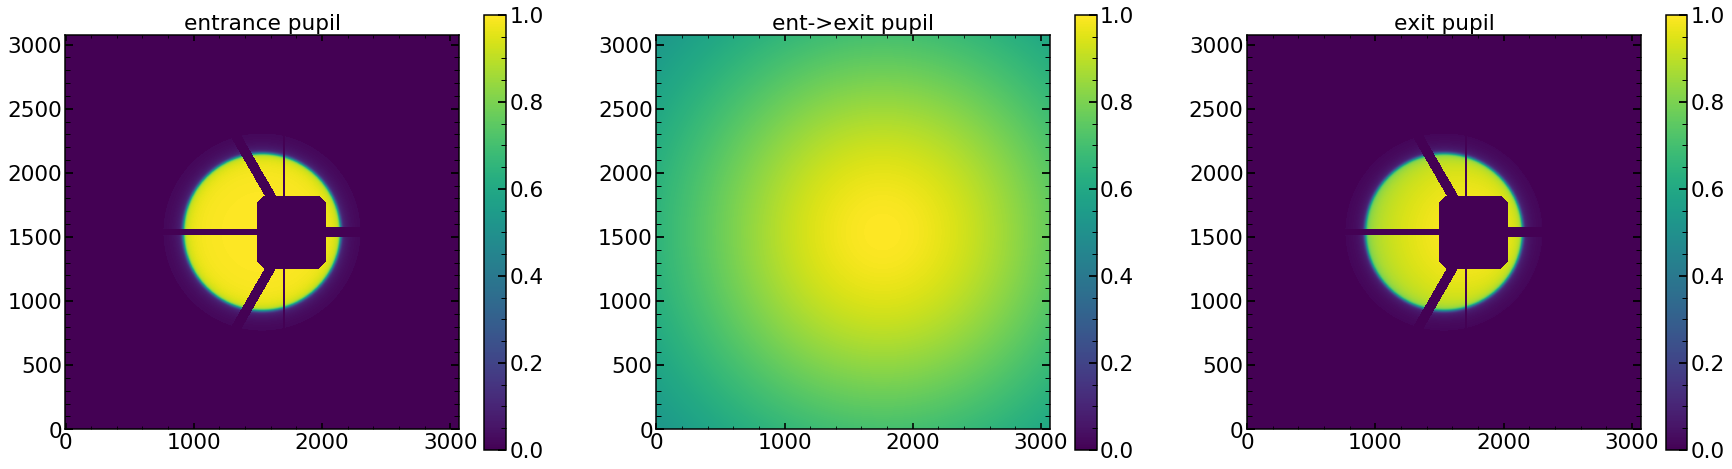

In [12]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

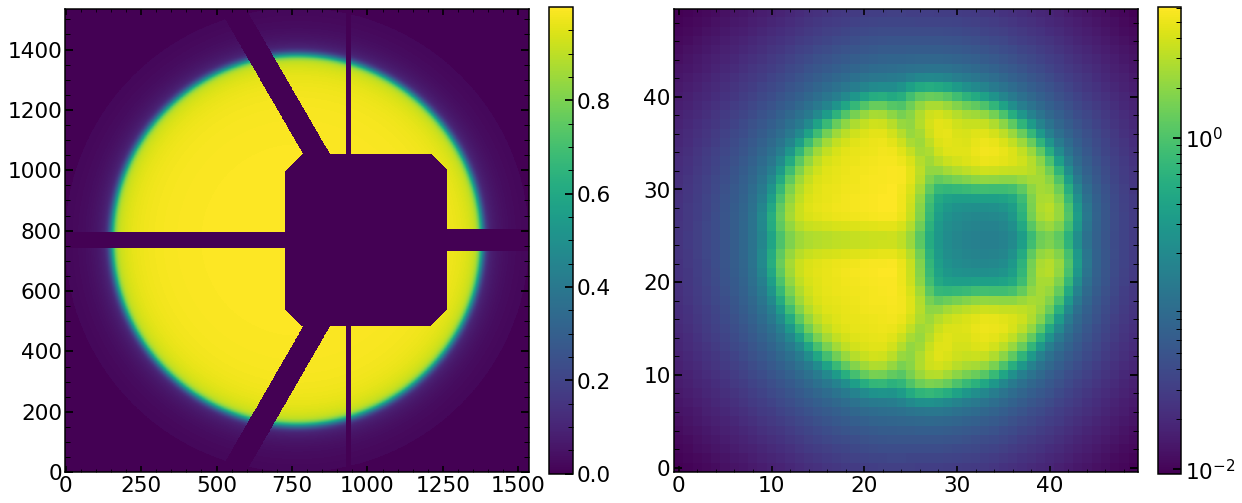

In [13]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

# First look at initial Subaru data

## raw

In [29]:
files_Apr_30=glob.glob("/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-04-30/PFSA00*12.fits")
number_Apr_30=[]
for files in files_Apr_30:
    number_Apr_30.append(int(files[56:60]))
    
files_May_01=glob.glob("/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-05-01/PFSA00*12.fits")
number_May_01=[]
for files in files_May_01:
    number_May_01.append(int(files[56:60]))

In [30]:
from astropy.io import *

res_Apr_30=[]
for i in number_Apr_30:
    hdul = fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-04-30/PFSA00'+str(i)+'12.fits')
    res_Apr_30.append([i,hdul[0].header['IMAGETYP']])
   
res_Apr_30=np.array(res_Apr_30)

res_May_01=[]
for i in number_May_01:
    hdul = fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-05-01/PFSA00'+str(i)+'12.fits')
    res_May_01.append([i,hdul[0].header['IMAGETYP']])
   
res_May_01=np.array(res_May_01)

In [31]:
res_May_01


array([['4355', 'arc'],
       ['4356', 'arc'],
       ['4357', 'arc'],
       ['4358', 'arc'],
       ['4359', 'arc'],
       ['4360', 'arc'],
       ['4361', 'arc'],
       ['4362', 'arc'],
       ['4363', 'arc'],
       ['4364', 'arc'],
       ['4365', 'arc'],
       ['4366', 'arc'],
       ['4367', 'arc'],
       ['4368', 'arc'],
       ['4369', 'arc'],
       ['4370', 'arc'],
       ['4371', 'arc'],
       ['4372', 'arc'],
       ['4373', 'arc'],
       ['4374', 'arc'],
       ['4375', 'arc'],
       ['4376', 'arc'],
       ['4377', 'arc'],
       ['4378', 'arc'],
       ['4379', 'arc'],
       ['4380', 'arc'],
       ['4381', 'arc'],
       ['4382', 'arc'],
       ['4383', 'arc'],
       ['4384', 'arc'],
       ['4385', 'arc'],
       ['4386', 'arc'],
       ['4387', 'arc'],
       ['4388', 'arc'],
       ['4389', 'arc'],
       ['4390', 'arc'],
       ['4391', 'arc'],
       ['4392', 'arc'],
       ['4393', 'arc'],
       ['4394', 'arc'],
       ['4395', 'arc'],
       ['4396', 

## detrended 

In [54]:
run=21352
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/Jun_2019_run1/rerun/rerun_1/detrend/calExp/2019-07-26/'
data_LAM=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata_LAM=data_LAM[1].data

In [55]:
run=4342
DATA_FOLDER='/Volumes/Saturn_USA/PFS/ReducedData/May2020/rerun_1/detrend/calExp/2020-04-30/'
data_Subaru=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-SA00'+str(run+0)+'r1.fits')
scidata_Subaru=data_Subaru[1].data
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

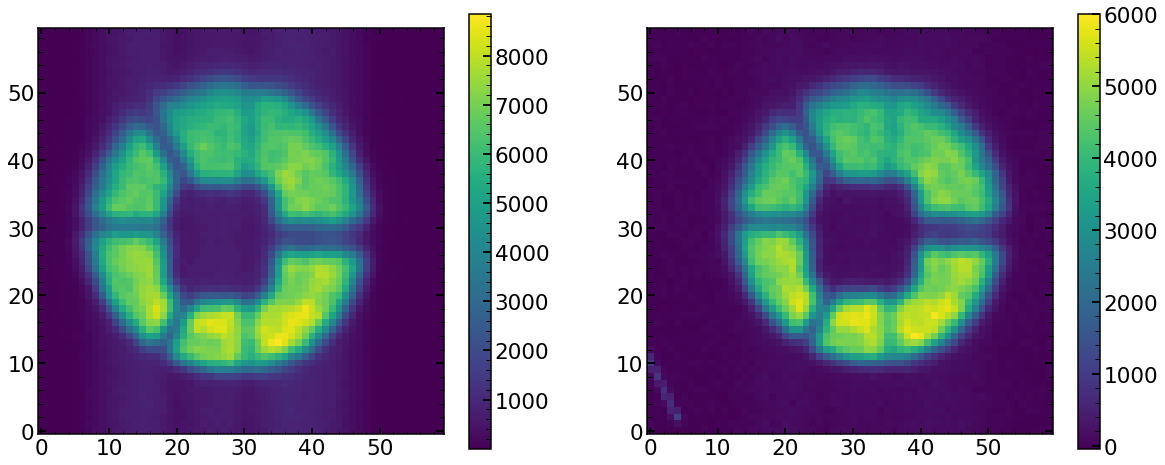

In [57]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(scidata_LAM[838-30:838+30,1610-30:1610+30])
plt.colorbar()

plt.subplot(122)
plt.imshow(scidata_Subaru[838-30:838+30,1610-30:1610+30])
plt.colorbar()

## Dithered data 

In [91]:
image_index=57



run_00=4440
sci_data_dithered_Subaru=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')

run_00=21256
sci_data_dithered_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')

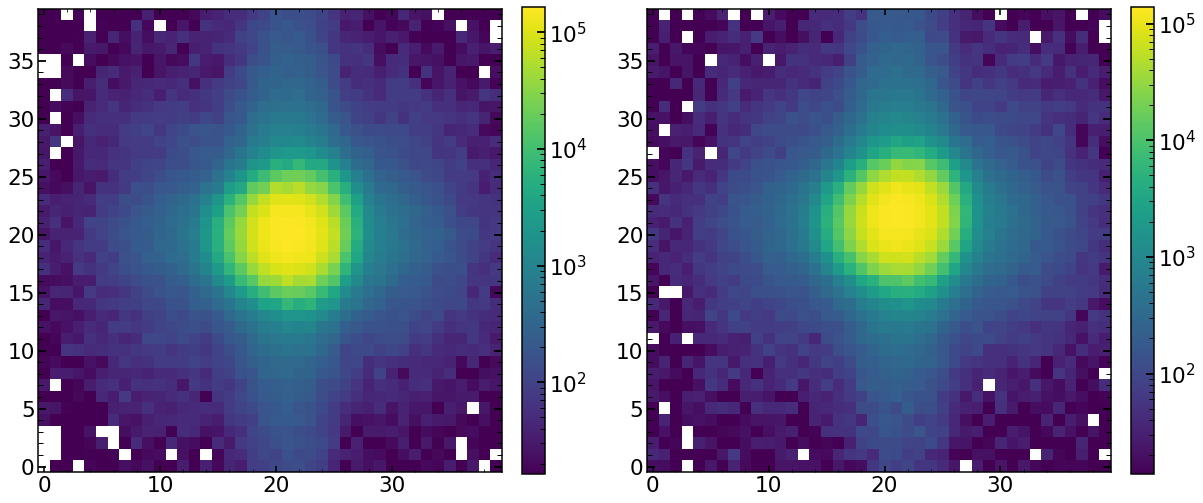

In [92]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(sci_data_dithered_Subaru,norm=LogNorm(),origin='lower',vmax=np.max(sci_data_dithered_Subaru),vmin=np.max(sci_data_dithered_Subaru)/10**4)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(sci_data_dithered_LAM,norm=LogNorm(),origin='lower',vmax=np.max(sci_data_dithered_LAM),vmin=np.max(sci_data_dithered_LAM)/10**4)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

(21.22372796817096, 20.029198042511137)
(21.312841585816727, 21.3087426960759)


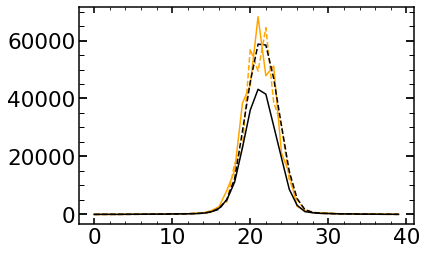

In [102]:
print(find_centroid_of_flux(sci_data_dithered_Subaru))
print(find_centroid_of_flux(sci_data_dithered_LAM))

plt.plot(sci_data_dithered_Subaru[24],color='orange',ls='--')
plt.plot(sci_data_dithered_Subaru[16],color='orange')

plt.plot(sci_data_dithered_LAM[25],color='black',ls='--')
plt.plot(sci_data_dithered_LAM[17],color='black')

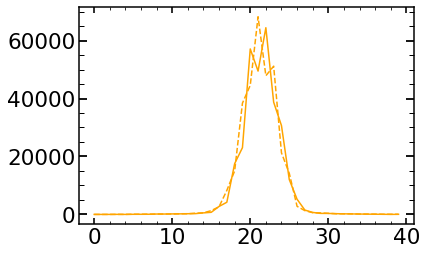

In [111]:
plt.plot(sci_data_dithered_Subaru[16],color='orange',ls='--')
plt.plot(sci_data_dithered_Subaru[24],color='orange')

# Dithering 

## init 

In [143]:
results_of_fit_many_direct_HgAr_from_Apr1520.iloc[0].values[:42]  

array([    1.05790084,     0.26321547,    -0.13693055,     0.49162332,
           0.64037551,     0.21823163,    -0.34700344,    -0.02946509,
          -0.13569922,    -0.11387118,    -0.01191344,     0.02439062,
          -0.02797068,     0.03029862,     0.01313367,     0.03109434,
          -0.0262689 ,     0.00795521,     0.01109555,     0.68450024,
           0.09964994,    -0.21008102,    -0.0277644 ,     0.05337982,
           0.05923652,     0.00003847,     0.00003846,     0.97673481,
           0.94835874,     0.00526606,    -0.03042255,     0.92485058,
           0.05235101,     0.64566828,     0.99396613,     0.61547169,
       45188.33516184,     2.02598383,     0.00121803,     0.35      ,
           1.78057077,     0.99930545])

In [144]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((40,40))
var_image_unit=np.ones((40,40))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=2,save=1,verbosity=1,npix=1536)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28e
npix_value:1536
Science image shape is: (40, 40)
Top left pixel value of the science image is: 1.0
Variance image shape is: (40, 40)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (40, 40)
Sum of mask image is: 0.0
Dithering value is: 2

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    1.05790084     0.26321547    -0.13693055     0.49162332
     0.64037551     0.21823163    -0.34700344    -0.02946509
    -0.13569922    -0.11387118    -0.01191344     0.02439062
    -0.02797068     0.03029862     0.01313367     0.03109434
    -0.0262689      0.00795521     0.01109555     0.68450024
     0.09964994    -0.21008102    -0.0277644      0.05337982
     0.05923652     0.00003847     0.00003846     0.97673481
     0.94835874     0.00526606    -0.03042255     0.92485058
     0.05235101     0.645668

TypeError: 'float' object is not subscriptable

In [138]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

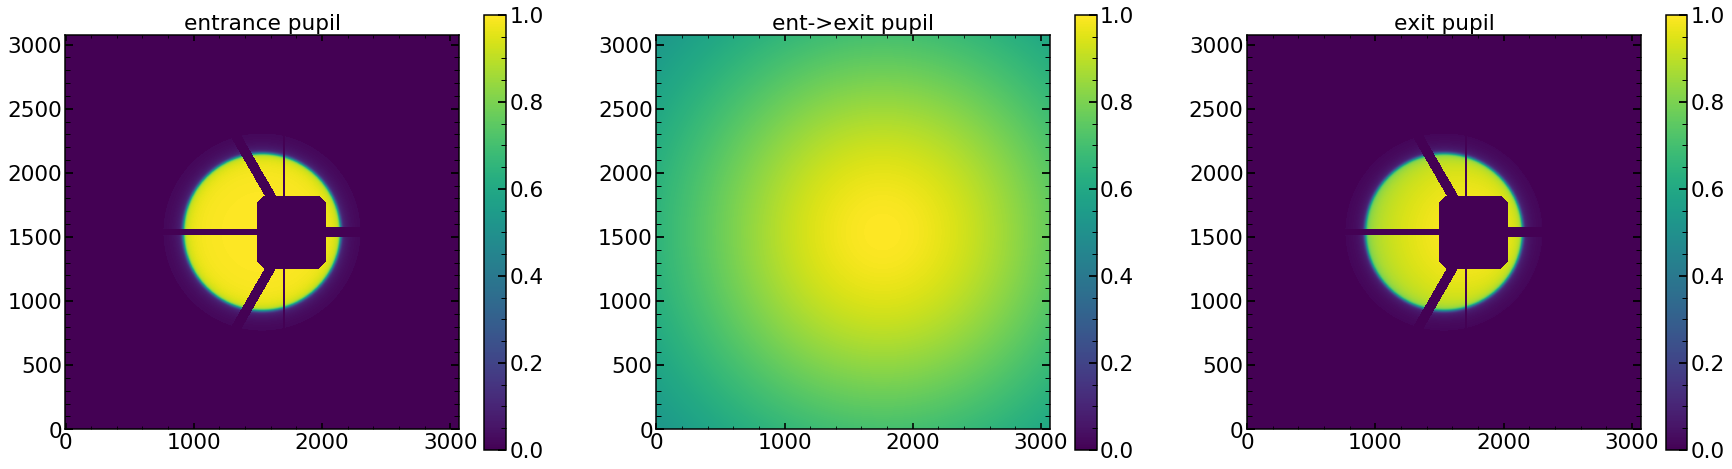

In [139]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

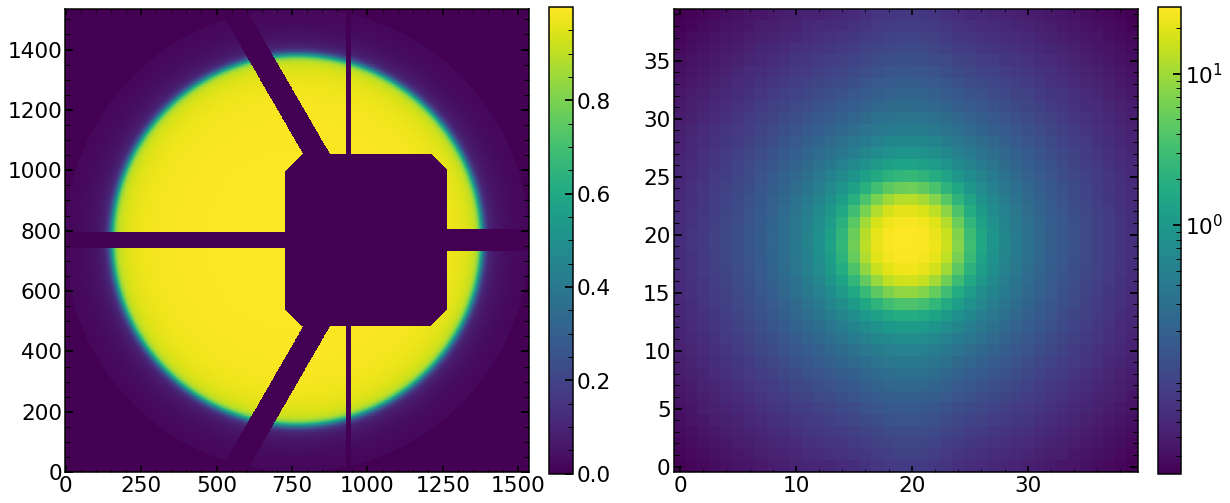

In [140]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

## many dithered images 

In [208]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_HgAr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Ne_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Kr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Apr1520=pickle.load(f)

In [209]:
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=2,save=0,verbosity=0,npix=1536,zmax=22,simulation_00=1) 

for i in tqdm(range(84)):
    allparameters_proposal=results_of_fit_many_direct_HgAr_from_Apr1520.iloc[i].values[:42]  
    res=model(allparameters_proposal,return_Image=True)
    res_iapetus=res[1]
    np.save('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D - Dithering/res_iapetus'+str(i),res_iapetus)

  0%|                                                                                                                             | 0/84 [00:00<?, ?it/s]

npix_value:1536


  0%|                                                                                                                             | 0/84 [00:04<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D - Dithering/res_iapetus0.npy'

In [210]:
    optPsf_cut_fiber_convolved_downsampled=res_iapetus
    optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
    optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
    optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
    optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]
    pos0p_sim=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00_sim
    posp0_sim=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00_sim
    pospp_sim=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00_sim
    pos_4_sim=np.array([pos00_sim,pos0p_sim,posp0_sim,pospp_sim])    

NameError: name 'pos00_sim' is not defined

In [239]:
pos_4

array([[10.35266578,  9.72861757],
       [-0.03163216,  0.65614292],
       [ 0.47886404,  0.07788084],
       [ 0.49430918,  0.53606718]])

In [241]:
np.zeros((4,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [246]:
## pp

pp_run=[]
run_00=4768
list_of_pp_9_image_index=[]
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
            optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
            posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
            pospp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00
            pos_4=np.array([pos00,pos0p,posp0,pospp])  
            pp_run.append(pos_4)
            list_of_pp_9_image_index.append(image_index)
        else:
            pp_run.append(np.ones((4,2))*-99)
    except:
        pp_run.append(np.ones((4,2))*-99)  
pos_4_pp=np.array(pp_run)
    
mm_run=[]
run_00=4720
list_of_mm_9_image_index=[]
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_mm=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_m0=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_0m=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            posm0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_m0))-pos00
            pos0m=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0m))-pos00
            posmm=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_mm))-pos00
            pos_4=np.array([pos00,posm0,pos0m,posmm])  
            mm_run.append(pos_4)
            list_of_mm_9_image_index.append(image_index)
        else:
            mm_run.append(np.ones((4,2))*-99)
    except:
        mm_run.append(np.ones((4,2))*-99)
pos_4_mm=np.array(mm_run)  

mp_run=[]
run_00=4732
list_of_mp_9_image_index=[]
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_m0=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_mp=optPsf_cut_fiber_convolved_downsampled[1::2,0::2]
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            posmp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_mp))-pos00
            posm0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_m0))-pos00
            pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
            pos_4=np.array([pos00,posmp,posm0,pos0p])  
            mp_run.append(pos_4)
            list_of_mp_9_image_index.append(image_index)
        else:
            mp_run.append(np.ones((4,2))*-99)
    except:
        mp_run.append(np.ones((4,2))*-99)
pos_4_mp=np.array(mp_run)  
    
pm_run=[]
run_00=4756
list_of_pm_9_image_index=[]
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_0m=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
            optPsf_cut_fiber_convolved_downsampled_pm=optPsf_cut_fiber_convolved_downsampled[0::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            pos0m=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0m))-pos00
            pospm=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pm))-pos00
            posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
            pos_4=np.array([pos00,pos0m,pospm,posp0])  
            pm_run.append(pos_4)
            list_of_pm_9_image_index.append(image_index)
        else:
            pm_run.append(np.ones((4,2))*-99)
    except:
        pm_run.append(np.ones((4,2))*-99)
pos_4_pm=np.array(pm_run)  

pp_run=[]
run_00=4440
list_of_pp_4_image_index=[]
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
            optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
            posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
            pospp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00
            pos_4=np.array([pos00,pos0p,posp0,pospp])  
            pp_run.append(pos_4)
            list_of_pp_image_index.append(image_index)
        else:
            pass
    except:
        pass   
pos_4_pp_via4=np.array(pp_run)

### LAM data 
pp_run=[]
run_00=21256
for image_index in tqdm(range(120)):
    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        optPsf_cut_fiber_convolved_downsampled_mask=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/mask"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
        if np.sum(optPsf_cut_fiber_convolved_downsampled_mask)==0:
            optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
            optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
            optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

            pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
            pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
            posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
            pospp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00
            pos_4=np.array([pos00,pos0p,posp0,pospp])  
            pp_run.append(pos_4)
        else:
            pass
    except:
        pass   
    
pos_4_pp_via4_LAM=np.array(pp_run)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 618.69it/s]


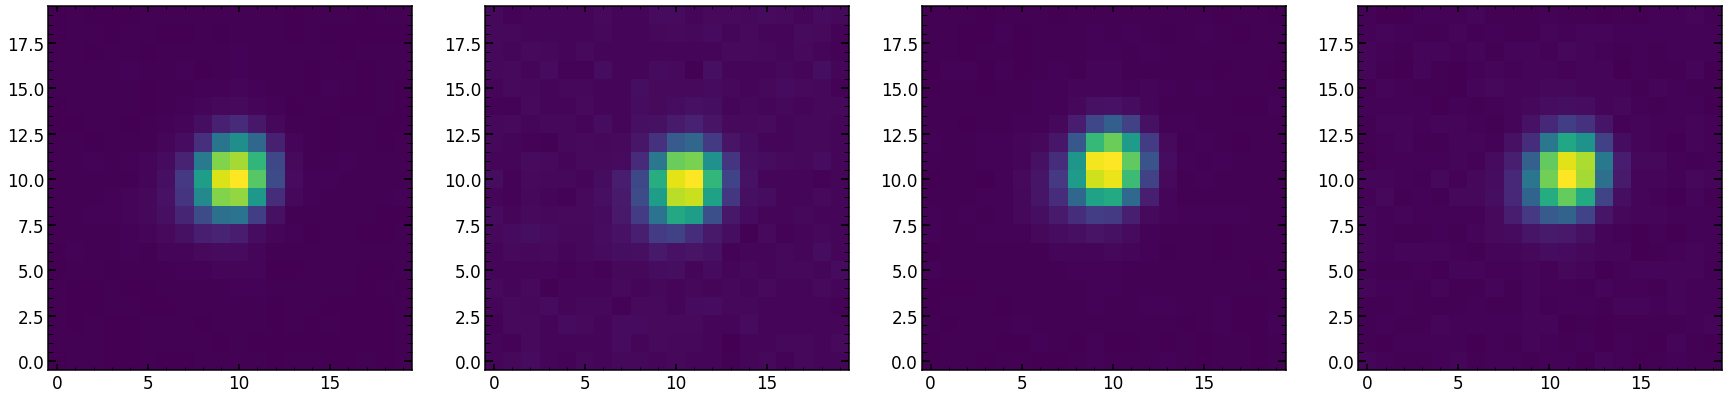

In [247]:
plt.figure(figsize=(30,10))
plt.subplot(141)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_0m)

plt.subplot(142)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_00)

plt.subplot(143)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_pm)

plt.subplot(144)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_pp)

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Delta y pixels')

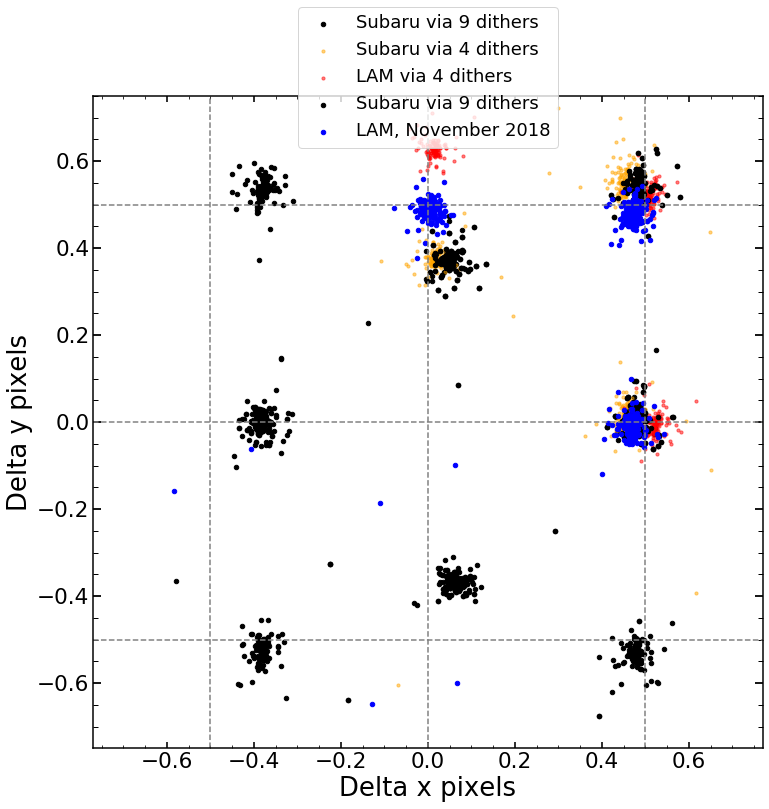

In [454]:
plt.figure(figsize=(12,12))

plt.scatter(pos_4_pp[:,1][:,0],pos_4_pp[:,1][:,1],label='Subaru via 9 dithers',color='black',s=20)
plt.scatter(pos_4_pp[:,2][:,0],pos_4_pp[:,2][:,1],color='black',s=20)
plt.scatter(pos_4_pp[:,3][:,0],pos_4_pp[:,3][:,1],color='black',s=20)

plt.scatter(pos_4_mm[:,1][:,0],pos_4_mm[:,1][:,1],color='black',s=20)
plt.scatter(pos_4_mm[:,2][:,0],pos_4_mm[:,2][:,1],color='black',s=20)
plt.scatter(pos_4_mm[:,3][:,0],pos_4_mm[:,3][:,1],color='black',s=20)

plt.scatter(pos_4_mp[:,1][:,0],pos_4_mp[:,1][:,1],color='black',s=20)
plt.scatter(pos_4_mp[:,2][:,0],pos_4_mp[:,2][:,1],color='black',s=20)
plt.scatter(pos_4_mp[:,3][:,0],pos_4_mp[:,3][:,1],color='black',s=20)

plt.scatter(pos_4_pm[:,1][:,0],pos_4_pm[:,1][:,1],color='black',s=20)
plt.scatter(pos_4_pm[:,2][:,0],pos_4_pm[:,2][:,1],color='black',s=20)
plt.scatter(pos_4_pm[:,3][:,0],pos_4_pm[:,3][:,1],color='black',s=20)

plt.scatter(pos_4_pp_via4[:,1][:,0],pos_4_pp_via4[:,1][:,1],label='Subaru via 4 dithers',color='orange',s=10,alpha=0.5)
plt.scatter(pos_4_pp_via4[:,2][:,0],pos_4_pp_via4[:,2][:,1],color='orange',s=10,alpha=0.5)
plt.scatter(pos_4_pp_via4[:,3][:,0],pos_4_pp_via4[:,3][:,1],color='orange',s=10,alpha=0.5)

plt.scatter(pos_4_pp_via4_LAM[:,1][:,0],pos_4_pp_via4_LAM[:,1][:,1],label='LAM via 4 dithers',color='red',s=10,alpha=0.5)
plt.scatter(pos_4_pp_via4_LAM[:,2][:,0],pos_4_pp_via4_LAM[:,2][:,1],color='red',s=10,alpha=0.5)
plt.scatter(pos_4_pp_via4_LAM[:,3][:,0],pos_4_pp_via4_LAM[:,3][:,1],color='red',s=10,alpha=0.5)

plt.scatter(pos_4_pp[:,1][:,0],pos_4_pp[:,1][:,1],label='Subaru via 9 dithers',color='black',s=20)
plt.scatter(pos_4_pp[:,2][:,0],pos_4_pp[:,2][:,1],color='black',s=20)
plt.scatter(pos_4_pp[:,3][:,0],pos_4_pp[:,3][:,1],color='black',s=20)

plt.scatter(pos_4_pp_November_2018[:,1][:,0],pos_4_pp_November_2018[:,1][:,1],label='LAM, November 2018',color='blue',s=20)
plt.scatter(pos_4_pp_November_2018[:,2][:,0],pos_4_pp_November_2018[:,2][:,1],color='blue',s=20)
plt.scatter(pos_4_pp_November_2018[:,3][:,0],pos_4_pp_November_2018[:,3][:,1],color='blue',s=20)


plt.axes().set_aspect('equal', 'datalim')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.axhline(-0.5,color='gray',ls='--')
plt.axhline(0,color='gray',ls='--')
plt.axhline(+0.5,color='gray',ls='--')

plt.axvline(-0.5,color='gray',ls='--')
plt.axvline(0,color='gray',ls='--')
plt.axvline(0.5,color='gray',ls='--')


plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.xlabel('Delta x pixels')
plt.ylabel('Delta y pixels')

## Further dithering 

### LAM November 2018

In [271]:
glob.glob('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/*Dithered.npy')

['/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var860056HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var860061HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci860094HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var860038HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var869064Ne_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci860010HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci860027HgAr_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var869011Ne_Stacked_Dithered.npy',
 '/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/var86008HgAr_Stacked_Dithered.npy',
 '/Use

In [272]:
optPsf_cut_fiber_convolved_downsampled_8600=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci860053HgAr_Stacked_Dithered.npy")

In [453]:
pp_run_LAM_Nov18=[]

for image_index in tqdm(range(120)):
    optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci8600"+str(image_index)+"HgAr_Stacked_Dithered.npy")
    try:
        optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
        optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
        optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
        optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

        pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
        pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
        posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
        pospp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00
        pos_4=np.array([pos00,pos0p,posp0,pospp])  
        pp_run_LAM_Nov18.append(pos_4)
    except:
        pass
    
    
for image_index in tqdm(range(120)):

    try:
        optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Stamps_cleaned/sci8690"+str(image_index)+"Ne_Stacked_Dithered.npy")
        optPsf_cut_fiber_convolved_downsampled_00=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
        optPsf_cut_fiber_convolved_downsampled_0p=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
        optPsf_cut_fiber_convolved_downsampled_p0=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
        optPsf_cut_fiber_convolved_downsampled_pp=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

        pos00=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00))
        pos0p=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p))-pos00
        posp0=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_p0))-pos00
        pospp=np.array(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_pp))-pos00
        pos_4=np.array([pos00,pos0p,posp0,pospp])  
        pp_run_LAM_Nov18.append(pos_4)
    except:
        pass
    
pos_4_pp_November_2018=np.array(pp_run_LAM_Nov18)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 470.91it/s]


In [285]:
pos_4_pp_November_2018[:,1]

array([[-0.01586535,  0.65097209],
       [ 0.01467263,  0.61131967],
       [ 0.05907319,  0.59987297],
       ...,
       [ 0.00529219,  0.48258881],
       [ 0.0051054 ,  0.48819945],
       [ 0.00420017,  0.4890955 ]])

### Transforming raw into quantiles 

In [455]:
# LAM November 2018/ 4 dithers

pos_4_pp_November_2018_quantiles=[]
for i in [1,2,3]:
    pos_4_pp_November_2018_quantiles.append(np.concatenate(([np.quantile(pos_4_pp_November_2018[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pp_November_2018[:,i][:,1],[0.5,0.16,0.84])])))
    
pos_4_pp_November_2018_quantiles=np.array(pos_4_pp_November_2018_quantiles)

# transforming x quantiles in x errors 
pos_4_pp_November_2018_quantiles[:,1]=(-pos_4_pp_November_2018_quantiles[:,0]+pos_4_pp_November_2018_quantiles[:,1])*(-1)
pos_4_pp_November_2018_quantiles[:,2]=-pos_4_pp_November_2018_quantiles[:,0]+pos_4_pp_November_2018_quantiles[:,2]

# transforming y quantiles in y errors 
pos_4_pp_November_2018_quantiles[:,4]=(-pos_4_pp_November_2018_quantiles[:,3]+pos_4_pp_November_2018_quantiles[:,4])*(-1)
pos_4_pp_November_2018_quantiles[:,5]=-pos_4_pp_November_2018_quantiles[:,3]+pos_4_pp_November_2018_quantiles[:,5]

In [456]:
# Subaru_May_2020 /4 dithers

pos_4_pp_Subaru_May_2019_quantiles=[]
for i in [1,2,3]:
    pos_4_pp_Subaru_May_2019_quantiles.append(np.concatenate(([np.quantile(pos_4_pp_via4[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pp_via4[:,i][:,1],[0.5,0.16,0.84])])))
    
pos_4_pp_Subaru_May_2019_quantiles=np.array(pos_4_pp_Subaru_May_2019_quantiles)

# transforming x quantiles in x errors 
pos_4_pp_Subaru_May_2019_quantiles[:,1]=(-pos_4_pp_Subaru_May_2019_quantiles[:,0]+pos_4_pp_Subaru_May_2019_quantiles[:,1])*(-1)
pos_4_pp_Subaru_May_2019_quantiles[:,2]=-pos_4_pp_Subaru_May_2019_quantiles[:,0]+pos_4_pp_Subaru_May_2019_quantiles[:,2]

# transforming y quantiles in y errors 
pos_4_pp_Subaru_May_2019_quantiles[:,4]=(-pos_4_pp_Subaru_May_2019_quantiles[:,3]+pos_4_pp_Subaru_May_2019_quantiles[:,4])*(-1)
pos_4_pp_Subaru_May_2019_quantiles[:,5]=-pos_4_pp_Subaru_May_2019_quantiles[:,3]+pos_4_pp_Subaru_May_2019_quantiles[:,5]

In [457]:
# Lam July /4 dithers

pos_4_pp_LAM_July_2019_quantiles=[]
for i in [1,2,3]:
    pos_4_pp_LAM_July_2019_quantiles.append(np.concatenate(([np.quantile(pos_4_pp_via4_LAM[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pp_via4_LAM[:,i][:,1],[0.5,0.16,0.84])])))
    
pos_4_pp_LAM_July_2019_quantiles=np.array(pos_4_pp_LAM_July_2019_quantiles)

# transforming x quantiles in x errors 
pos_4_pp_LAM_July_2019_quantiles[:,1]=(-pos_4_pp_LAM_July_2019_quantiles[:,0]+pos_4_pp_LAM_July_2019_quantiles[:,1])*(-1)
pos_4_pp_LAM_July_2019_quantiles[:,2]=-pos_4_pp_LAM_July_2019_quantiles[:,0]+pos_4_pp_LAM_July_2019_quantiles[:,2]

# transforming y quantiles in y errors 
pos_4_pp_LAM_July_2019_quantiles[:,4]=(-pos_4_pp_LAM_July_2019_quantiles[:,3]+pos_4_pp_LAM_July_2019_quantiles[:,4])*(-1)
pos_4_pp_LAM_July_2019_quantiles[:,5]=-pos_4_pp_LAM_July_2019_quantiles[:,3]+pos_4_pp_LAM_July_2019_quantiles[:,5]

In [458]:
# Subaru_May_2020 /9 dithers

pos_4_pp_Subaru_May_2019_quantiles_9=[]
for i in [1,2,3]:
    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pp[:,i][:,1],[0.5,0.16,0.84])])))
for i in [1,2,3]:
    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_mm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_mm[:,i][:,1],[0.5,0.16,0.84])])))   
for i in [1,2,3]:
    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_mp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_mp[:,i][:,1],[0.5,0.16,0.84])])))   
for i in [1,2,3]:
    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pm[:,i][:,1],[0.5,0.16,0.84])])))   
    
    
pos_4_pp_Subaru_May_2019_quantiles_9=np.array(pos_4_pp_Subaru_May_2019_quantiles_9)

# transforming x quantiles in x errors 
pos_4_pp_Subaru_May_2019_quantiles_9[:,1]=(-pos_4_pp_Subaru_May_2019_quantiles_9[:,0]+pos_4_pp_Subaru_May_2019_quantiles_9[:,1])*(-1)
pos_4_pp_Subaru_May_2019_quantiles_9[:,2]=-pos_4_pp_Subaru_May_2019_quantiles_9[:,0]+pos_4_pp_Subaru_May_2019_quantiles_9[:,2]

# transforming y quantiles in y errors 
pos_4_pp_Subaru_May_2019_quantiles_9[:,4]=(-pos_4_pp_Subaru_May_2019_quantiles_9[:,3]+pos_4_pp_Subaru_May_2019_quantiles_9[:,4])*(-1)
pos_4_pp_Subaru_May_2019_quantiles_9[:,5]=-pos_4_pp_Subaru_May_2019_quantiles_9[:,3]+pos_4_pp_Subaru_May_2019_quantiles_9[:,5]

In [459]:
# LAM_May_2019 /9 dithers
# comming from cutting notebook

pos_4_LAM_May19_via_9_pp=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_via_9_pp.npy')
pos_4_LAM_May19_via_9_mm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_via_9_mm.npy')
pos_4_LAM_May19_via_9_mp_pm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_via_9_pm_mp.npy')

pos_4_pp_LAMMay_2019_quantiles_9=[]
for i in [1,2,3]:
    pos_4_pp_LAMMay_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_May19_via_9_pp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_May19_via_9_pp[:,i][:,1],[0.5,0.16,0.84])])))
for i in [1,2,3]:
    pos_4_pp_LAMMay_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_May19_via_9_mm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_May19_via_9_mm[:,i][:,1],[0.5,0.16,0.84])])))   
for i in [1,2,3]:
    pos_4_pp_LAMMay_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_May19_via_9_mp_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_May19_via_9_mp_pm[:,i][:,1],[0.5,0.16,0.84])])))   
#for i in [1,2,3]:
#    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pm[:,i][:,1],[0.5,0.16,0.84])])))   
    
    
pos_4_pp_LAMMay_2019_quantiles_9=np.array(pos_4_pp_LAMMay_2019_quantiles_9)

# transforming x quantiles in x errors 
pos_4_pp_LAMMay_2019_quantiles_9[:,1]=(-pos_4_pp_LAMMay_2019_quantiles_9[:,0]+pos_4_pp_LAMMay_2019_quantiles_9[:,1])*(-1)
pos_4_pp_LAMMay_2019_quantiles_9[:,2]=-pos_4_pp_LAMMay_2019_quantiles_9[:,0]+pos_4_pp_LAMMay_2019_quantiles_9[:,2]

# transforming y quantiles in y errors 
pos_4_pp_LAMMay_2019_quantiles_9[:,4]=(-pos_4_pp_LAMMay_2019_quantiles_9[:,3]+pos_4_pp_LAMMay_2019_quantiles_9[:,4])*(-1)
pos_4_pp_LAMMay_2019_quantiles_9[:,5]=-pos_4_pp_LAMMay_2019_quantiles_9[:,3]+pos_4_pp_LAMMay_2019_quantiles_9[:,5]

In [463]:
# LAM_June_2019 /9 dithers
# comming from cutting notebook

pos_4_LAM_June7_via_9_pp=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pp.npy')
pos_4_LAM_June7_via_9_mm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_mm.npy')
pos_4_LAM_June7via_9_mp_pm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pm_mp.npy')

pos_4_pp_LAMJune_2019_quantiles_9=[]
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_pp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7_via_9_pp[:,i][:,1],[0.5,0.16,0.84])])))
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_mm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7_via_9_mm[:,i][:,1],[0.5,0.16,0.84])])))   
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][:,1],[0.5,0.16,0.84])])))   
#for i in [1,2,3]:
#    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pm[:,i][:,1],[0.5,0.16,0.84])])))   
    
    
pos_4_pp_LAMJune_2019_quantiles_9=np.array(pos_4_pp_LAMJune_2019_quantiles_9)

# transforming x quantiles in x errors 
pos_4_pp_LAMJune_2019_quantiles_9[:,1]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,1])*(-1)
pos_4_pp_LAMJune_2019_quantiles_9[:,2]=-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,2]

# transforming y quantiles in y errors 
pos_4_pp_LAMJune_2019_quantiles_9[:,4]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,4])*(-1)
pos_4_pp_LAMJune_2019_quantiles_9[:,5]=-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,5]

In [502]:
# Lam Sep /4 dithers
pos_4_LAM_Sep_via_4_pp=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_Sep.npy')

pos_4_pp_LAM_Sep_2019_quantiles=[]
for i in [1,2,3]:
    pos_4_pp_LAM_Sep_2019_quantiles.append(np.concatenate(([np.quantile(pos_4_LAM_Sep_via_4_pp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_Sep_via_4_pp[:,i][:,1],[0.5,0.16,0.84])])))
    
pos_4_pp_LAM_Sep_2019_quantiles=np.array(pos_4_pp_LAM_Sep_2019_quantiles)

# transforming x quantiles in x errors 
pos_4_pp_LAM_Sep_2019_quantiles[:,1]=(-pos_4_pp_LAM_Sep_2019_quantiles[:,0]+pos_4_pp_LAM_Sep_2019_quantiles[:,1])*(-1)
pos_4_pp_LAM_Sep_2019_quantiles[:,2]=-pos_4_pp_LAM_Sep_2019_quantiles[:,0]+pos_4_pp_LAM_Sep_2019_quantiles[:,2]

# transforming y quantiles in y errors 
pos_4_pp_LAM_Sep_2019_quantiles[:,4]=(-pos_4_pp_LAM_Sep_2019_quantiles[:,3]+pos_4_pp_LAM_Sep_2019_quantiles[:,4])*(-1)
pos_4_pp_LAM_Sep_2019_quantiles[:,5]=-pos_4_pp_LAM_Sep_2019_quantiles[:,3]+pos_4_pp_LAM_Sep_2019_quantiles[:,5]

## Master plot

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Delta y pixels')

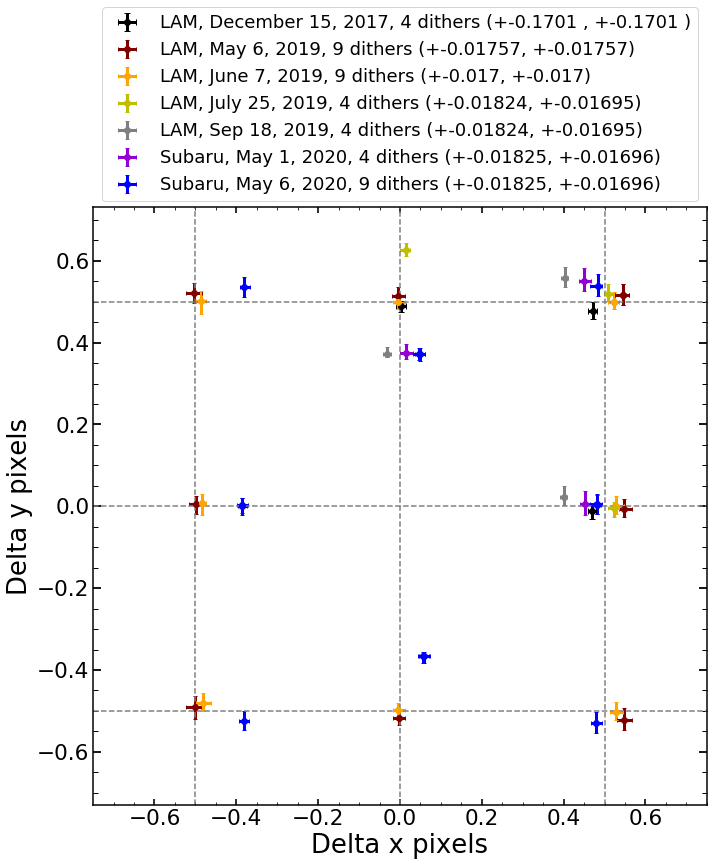

In [504]:
plt.figure(figsize=(11,11))

plt.errorbar(x=pos_4_pp_November_2018_quantiles[:,0],y=pos_4_pp_November_2018_quantiles[:,3],\
             xerr=np.transpose(pos_4_pp_November_2018_quantiles[:,1:3]),yerr=np.transpose(pos_4_pp_November_2018_quantiles[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=3,label='LAM, December 15, 2017, 4 dithers (+-0.1701 , +-0.1701 )',color='black')


plt.errorbar(x=pos_4_pp_LAMMay_2019_quantiles_9[:,0],y=pos_4_pp_LAMMay_2019_quantiles_9[:,3],\
             xerr=np.transpose(pos_4_pp_LAMMay_2019_quantiles_9[:,1:3]),yerr=np.transpose(pos_4_pp_LAMMay_2019_quantiles_9[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='LAM, May 6, 2019, 9 dithers (+-0.01757, +-0.01757)',color='maroon')

plt.errorbar(x=pos_4_pp_LAMJune_2019_quantiles_9[:,0],y=pos_4_pp_LAMJune_2019_quantiles_9[:,3],\
             xerr=np.transpose(pos_4_pp_LAMJune_2019_quantiles_9[:,1:3]),yerr=np.transpose(pos_4_pp_LAMJune_2019_quantiles_9[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='LAM, June 7, 2019, 9 dithers (+-0.017, +-0.017)',color='orange')

plt.errorbar(x=pos_4_pp_LAM_July_2019_quantiles[:,0],y=pos_4_pp_LAM_July_2019_quantiles[:,3],\
             xerr=np.transpose(pos_4_pp_LAM_July_2019_quantiles[:,1:3]),yerr=np.transpose(pos_4_pp_LAM_July_2019_quantiles[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='LAM, July 25, 2019, 4 dithers (+-0.01824, +-0.01695)',color='y')

plt.errorbar(x=pos_4_pp_LAM_Sep_2019_quantiles[:,0],y=pos_4_pp_LAM_Sep_2019_quantiles[:,3],\
             xerr=np.transpose(pos_4_pp_LAM_Sep_2019_quantiles[:,1:3]),yerr=np.transpose(pos_4_pp_LAM_Sep_2019_quantiles[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='LAM, Sep 18, 2019, 4 dithers (+-0.01824, +-0.01695)',color='gray')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles[:,0],y=pos_4_pp_Subaru_May_2019_quantiles[:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles[:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles[:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, 4 dithers (+-0.01825, +-0.01696)',color='darkviolet')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9[:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9[:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9[:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9[:,4:6]),\
             color='blue',elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 6, 2020, 9 dithers (+-0.01825, +-0.01696)')




plt.axes().set_aspect('equal', 'datalim')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35))

plt.axhline(-0.5,color='gray',ls='--')
plt.axhline(0,color='gray',ls='--')
plt.axhline(+0.5,color='gray',ls='--')

plt.axvline(-0.5,color='gray',ls='--')
plt.axvline(0,color='gray',ls='--')
plt.axvline(0.5,color='gray',ls='--')


plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.xlabel('Delta x pixels')
plt.ylabel('Delta y pixels')

In [471]:
# LAM July
run_00=21256
image_index=53
optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
optPsf_cut_fiber_convolved_downsampled_00_Lam_July=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
optPsf_cut_fiber_convolved_downsampled_0p_Lam_July=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
optPsf_cut_fiber_convolved_downsampled_p0_Lam_July=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
optPsf_cut_fiber_convolved_downsampled_pp_Lam_July=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]

# Subaru May 2019
run_00=4768
optPsf_cut_fiber_convolved_downsampled=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamps_cleaned/sci"+str(run_00)+str(image_index)+'HgAr_Stacked.npy')
optPsf_cut_fiber_convolved_downsampled_00_Sub_May=optPsf_cut_fiber_convolved_downsampled[1::2,1::2]
optPsf_cut_fiber_convolved_downsampled_0p_Sub_May=optPsf_cut_fiber_convolved_downsampled[::2,1::2]
optPsf_cut_fiber_convolved_downsampled_p0_Sub_May=optPsf_cut_fiber_convolved_downsampled[1::2,::2]
optPsf_cut_fiber_convolved_downsampled_pp_Sub_May=optPsf_cut_fiber_convolved_downsampled[0::2,0::2]
            
# LAM June 2019

Text(0.5, 1.0, 'Sub, May 2020:[10.33 10.22]')

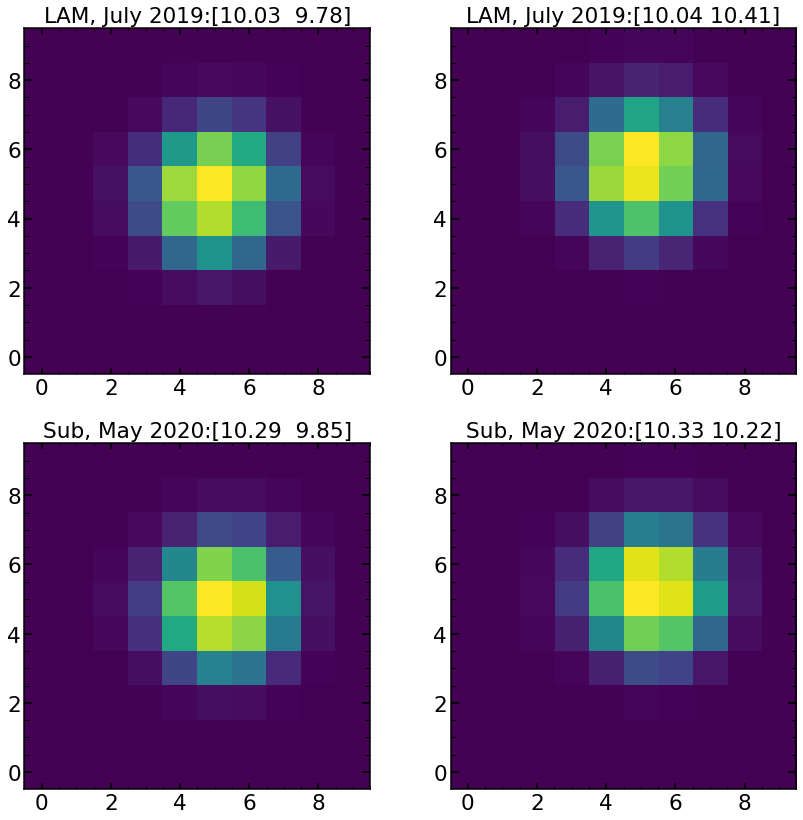

In [492]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_00_Lam_July[5:15,5:15])
plt.title('LAM, July 2019:'+str(np.round(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00_Lam_July),2)))

plt.subplot(2,2,2)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_0p_Lam_July[5:15,5:15])
plt.title('LAM, July 2019:'+str(np.round(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p_Lam_July),2)))

plt.subplot(2,2,3)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_00_Sub_May[5:15,5:15])
plt.title('Sub, May 2020:'+str(np.round(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_00_Sub_May),2)))

plt.subplot(2,2,4)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_0p_Sub_May[5:15,5:15])
plt.title('Sub, May 2020:'+str(np.round(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p_Sub_May),2)))

In [482]:
np.round(find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled_0p_Lam_July),2)

array([10.04, 10.41])

In [164]:
list_of_analyzed_image_index=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/list_of_analyzed_image_index_LAM_June_via_9_pp.npy')
pos_4_LAM_June7_via_9_pp=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pp.npy')
pos_4_LAM_June7_via_9_mm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_mm.npy')
pos_4_LAM_June7via_9_mp_pm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pm_mp.npy')


In [169]:
pos_4_LAM_June7_via_9_pp=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pp.npy')
pos_4_LAM_June7_via_9_mm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_mm.npy')
pos_4_LAM_June7via_9_mp_pm=np.load('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-584 (Dithering)/pos_4_LAM_June_via_9_pm_mp.npy')

pos_4_pp_LAMJune_2019_quantiles_9=[]
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_pp[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7_via_9_pp[:,i][:,1],[0.5,0.16,0.84])])))
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_mm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7_via_9_mm[:,i][:,1],[0.5,0.16,0.84])])))   
for i in [1,2,3]:
    pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][:,1],[0.5,0.16,0.84])])))   
#for i in [1,2,3]:
#    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pm[:,i][:,1],[0.5,0.16,0.84])])))   
    
    
pos_4_pp_LAMJune_2019_quantiles_9=np.array(pos_4_pp_LAMJune_2019_quantiles_9)

# transforming x quantiles in x errors 
pos_4_pp_LAMJune_2019_quantiles_9[:,1]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,1])*(-1)
pos_4_pp_LAMJune_2019_quantiles_9[:,2]=-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,2]

# transforming y quantiles in y errors 
pos_4_pp_LAMJune_2019_quantiles_9[:,4]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,4])*(-1)
pos_4_pp_LAMJune_2019_quantiles_9[:,5]=-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,5]

In [198]:
left_index=(finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['xc']<100].index).values
right_index=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['xc']>4000].index.values
bottom_index=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['yc']<800].index.values
top_index=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['yc']>3950].index.values
central_index=finalHgAr_Feb2020_dataset[(finalHgAr_Feb2020_dataset['yc']<2500)&(finalHgAr_Feb2020_dataset['yc']>1500)&\
                          (finalHgAr_Feb2020_dataset['xc']<2500)&(finalHgAr_Feb2020_dataset['xc']>1500)].index.values

In [263]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['yc']>4000]

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
11,2,59,4044,966.0642,1,HgAr,59,0,0,0,0
23,63,453,4020,966.0642,1,HgAr,453,0,0,0,0
35,192,840,4009,966.0642,1,HgAr,840,0,0,0,0
107,587,3633,4022,966.0642,1,HgAr,3702,0,0,0,0
119,650,4016,4044,966.0642,1,HgAr,4085,0,0,0,0


In [204]:
pos_4_pp_LAMJune_2019_quantiles_9_i=[]
for i_index in [left_index,right_index,bottom_index,top_index,central_index]:

    pos_4_pp_LAMJune_2019_quantiles_9=[]
    for i in [1,2,3]:
        pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_pp[:,i][i_index][:,0],[0.5,0.16,0.84]),\
                                                                  np.quantile(pos_4_LAM_June7_via_9_pp[:,i][i_index][:,1],[0.5,0.16,0.84])])))
    for i in [1,2,3]:
        pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7_via_9_mm[:,i][i_index][:,0],[0.5,0.16,0.84]),\
                                                                  np.quantile(pos_4_LAM_June7_via_9_mm[:,i][i_index][:,1],[0.5,0.16,0.84])])))   
    for i in [1,2,3]:
        pos_4_pp_LAMJune_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][i_index][:,0],[0.5,0.16,0.84]),\
                                                                  np.quantile(pos_4_LAM_June7via_9_mp_pm[:,i][i_index][:,1],[0.5,0.16,0.84])])))   
    #for i in [1,2,3]:
    #    pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm[:,i][:,0],[0.5,0.16,0.84]),np.quantile(pos_4_pm[:,i][:,1],[0.5,0.16,0.84])])))   


    pos_4_pp_LAMJune_2019_quantiles_9=np.array(pos_4_pp_LAMJune_2019_quantiles_9)

    # transforming x quantiles in x errors 
    pos_4_pp_LAMJune_2019_quantiles_9[:,1]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,1])*(-1)
    pos_4_pp_LAMJune_2019_quantiles_9[:,2]=-pos_4_pp_LAMJune_2019_quantiles_9[:,0]+pos_4_pp_LAMJune_2019_quantiles_9[:,2]

    # transforming y quantiles in y errors 
    pos_4_pp_LAMJune_2019_quantiles_9[:,4]=(-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,4])*(-1)
    pos_4_pp_LAMJune_2019_quantiles_9[:,5]=-pos_4_pp_LAMJune_2019_quantiles_9[:,3]+pos_4_pp_LAMJune_2019_quantiles_9[:,5]
    
    pos_4_pp_LAMJune_2019_quantiles_9_i.append(pos_4_pp_LAMJune_2019_quantiles_9)

In [238]:
list_of_pp_9_image_left_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [258]:
pos_4_pp_Subaru_May_2019_quantiles_9_i=[]
for i_index in [left_index,right_index,bottom_index,top_index,central_index]:
    pos_4_pp_Subaru_May_2019_quantiles_9=[]
    for i in [1,2,3]:
        pos_4_pp_index=pos_4_pp[:,i][i_index]
        pos_4_pp_index=pos_4_pp_index[pos_4_pp_index[:,0]>-99]
        pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pp_index[:,0],[0.5,0.16,0.84]),\
                                                                     np.quantile(pos_4_pp_index[:,1],[0.5,0.16,0.84])])))
    for i in [1,2,3]:
        pos_4_mm_index=pos_4_mm[:,i][i_index]
        pos_4_mm_index=pos_4_mm_index[pos_4_mm_index[:,0]>-99]
        pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_mm_index[:,0],[0.5,0.16,0.84]),\
                                                                     np.quantile(pos_4_mm_index[:,1],[0.5,0.16,0.84])])))   
    for i in [1,2,3]:
        pos_4_mp_index=pos_4_mp[:,i][i_index]
        pos_4_mp_index=pos_4_mp_index[pos_4_mp_index[:,0]>-99]
        pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_mp_index[:,0],[0.5,0.16,0.84]),\
                                                                     np.quantile(pos_4_mp_index[:,1],[0.5,0.16,0.84])])))   
    for i in [1,2,3]:
        pos_4_pm_index=pos_4_pm[:,i][i_index]
        pos_4_pm_index=pos_4_pm_index[pos_4_pm_index[:,0]>-99]
        pos_4_pp_Subaru_May_2019_quantiles_9.append(np.concatenate(([np.quantile(pos_4_pm_index[:,0],[0.5,0.16,0.84]),\
                                                                     np.quantile(pos_4_pm_index[:,1],[0.5,0.16,0.84])])))   


    pos_4_pp_Subaru_May_2019_quantiles_9=np.array(pos_4_pp_Subaru_May_2019_quantiles_9)

    # transforming x quantiles in x errors 
    pos_4_pp_Subaru_May_2019_quantiles_9[:,1]=(-pos_4_pp_Subaru_May_2019_quantiles_9[:,0]+pos_4_pp_Subaru_May_2019_quantiles_9[:,1])*(-1)
    pos_4_pp_Subaru_May_2019_quantiles_9[:,2]=-pos_4_pp_Subaru_May_2019_quantiles_9[:,0]+pos_4_pp_Subaru_May_2019_quantiles_9[:,2]

    # transforming y quantiles in y errors 
    pos_4_pp_Subaru_May_2019_quantiles_9[:,4]=(-pos_4_pp_Subaru_May_2019_quantiles_9[:,3]+pos_4_pp_Subaru_May_2019_quantiles_9[:,4])*(-1)
    pos_4_pp_Subaru_May_2019_quantiles_9[:,5]=-pos_4_pp_Subaru_May_2019_quantiles_9[:,3]+pos_4_pp_Subaru_May_2019_quantiles_9[:,5]
    
    
    pos_4_pp_Subaru_May_2019_quantiles_9_i.append(pos_4_pp_Subaru_May_2019_quantiles_9)

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0, 0.5, 'Delta y pixels')

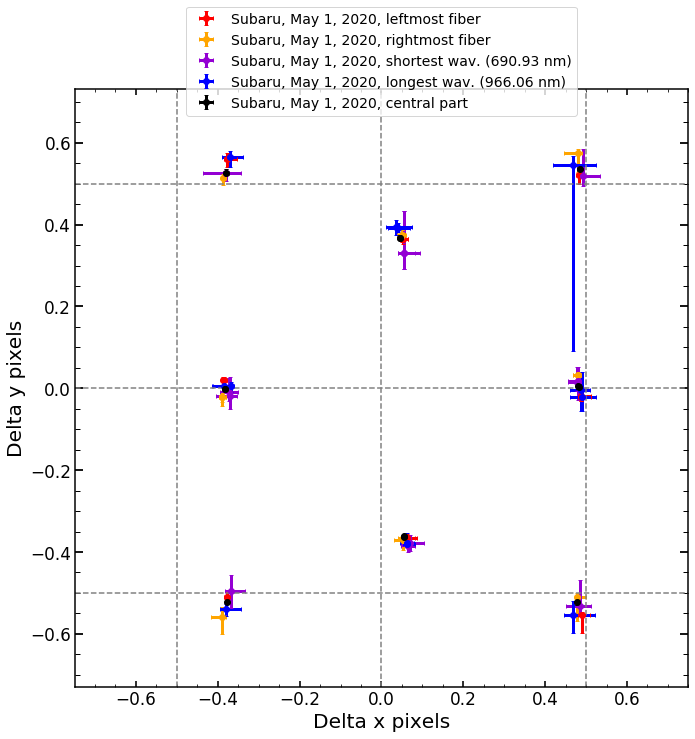

In [266]:
plt.figure(figsize=(11,11))

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, leftmost fiber',color='red')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, rightmost fiber',color='orange')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, shortest wav. (690.93 nm)',color='darkviolet')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, longest wav. (966.06 nm)',color='blue')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, central part',color='black')


plt.axes().set_aspect('equal', 'datalim')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.axhline(-0.5,color='gray',ls='--')
plt.axhline(0,color='gray',ls='--')
plt.axhline(+0.5,color='gray',ls='--')

plt.axvline(-0.5,color='gray',ls='--')
plt.axvline(0,color='gray',ls='--')
plt.axvline(0.5,color='gray',ls='--')


plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.xlabel('Delta x pixels')
plt.ylabel('Delta y pixels')

# Subtraction analysis 

## creation of model images

In [70]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [71]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [72]:
date='Apr1520'
obs=21604
obs_int=int(obs)
single_number='50'
image_index=int(single_number)
eps=5
arc='Ne'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]


if str(finalArc.loc[int(single_number)]['close'])=='0' or str(finalArc.loc[int(single_number)]['close'])=='0.5':
    double_source=1
elif str(finalArc.loc[int(single_number)]['close'])=='-1':
    print('can not be analyzed!')
else:
    double_source=None    

double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
print([double_source,double_sources_positions_ratios])

0d
[None, array([0, 0], dtype=object)]


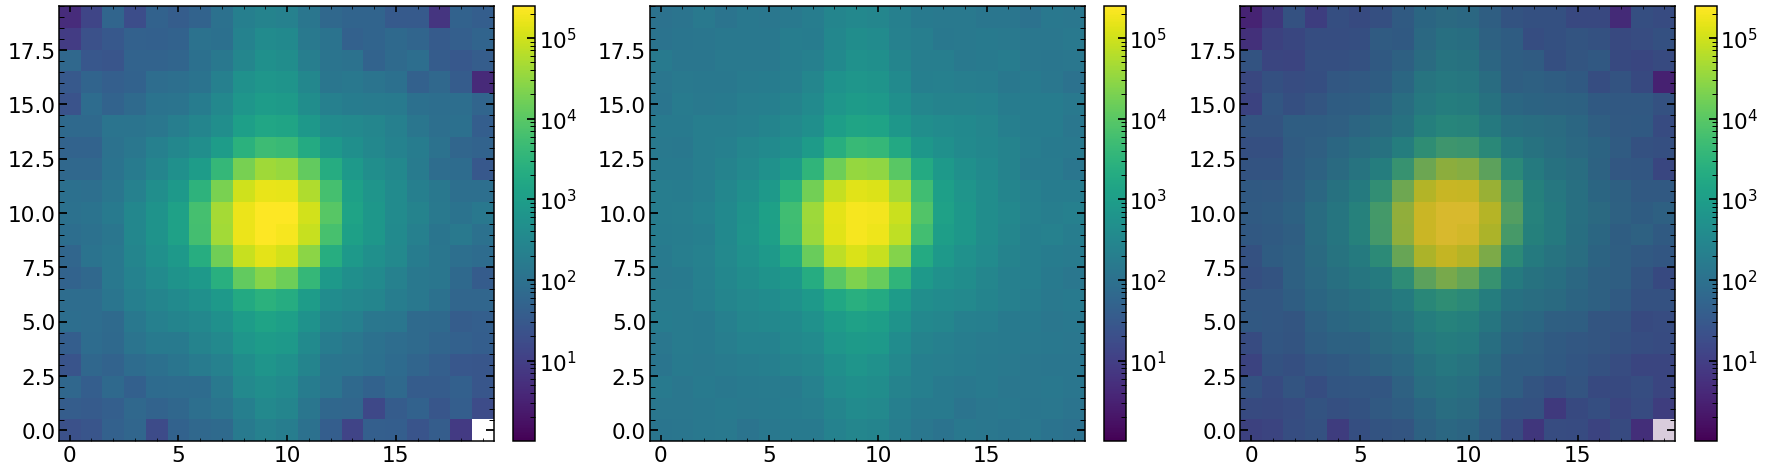

In [73]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [75]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain,like_min=single_analysis.create_likelihood()

(40, 390, 42) (196, 40, 42) (73, 390, 42) (252, 20, 42)
(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 6023.2841488955655
minimal chi2 reduced is: 22.303107756196578


In [79]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=0,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,simulation_00=0)   

model(minchain)

npix_value:1536


-6023.284148895527

chi**2 reduced is: 22.303107507515
Abs of residual divided by total flux is: 0.04234921365187992
Abs of residual divided by largest value of a flux in the image is: 0.06127857834734362


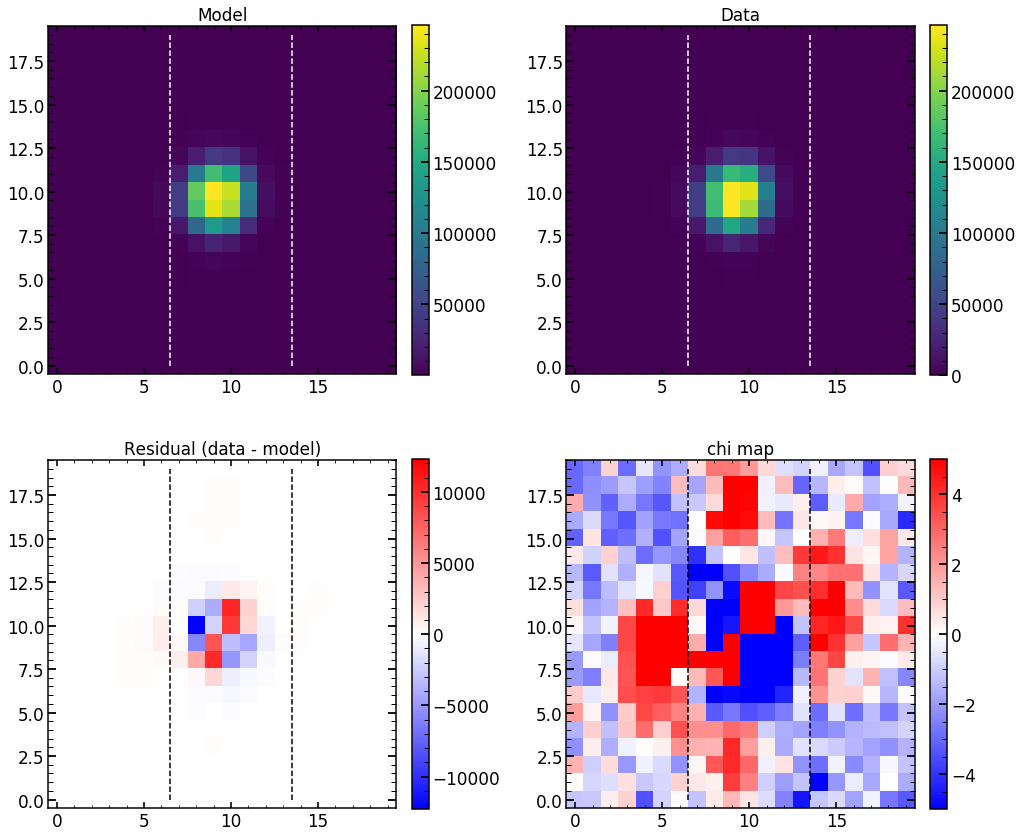

In [80]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

## comparison of subtractions 

In [41]:
finalHgAr_May2019=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl',allow_pickle=True)
finalNe_May2019=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl',allow_pickle=True)
# the names of the fibers
list_of_fiber_IDs=list(np.unique(finalHgAr_May2019['fiber'].values))

In [148]:
from astropy.io import fits

run_00=21604

DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/neven_20200526_subtract/2019-07-26/'
data00_subtract=fits.open(DATA_FOLDER+'v0'+str(run_00)+'/calExp-LA0'+str(run_00)+'r1.fits')[1].data
var00_subtract=fits.open(DATA_FOLDER+'v0'+str(run_00)+'/calExp-LA0'+str(run_00)+'r1.fits')[3].data

DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/neven_20200526_no_subtract/2019-07-26/'
data00_no_subtract=fits.open(DATA_FOLDER+'v0'+str(run_00)+'/calExp-LA0'+str(run_00)+'r1.fits')[1].data
var00_no_subtract=fits.open(DATA_FOLDER+'v0'+str(run_00)+'/calExp-LA0'+str(run_00)+'r1.fits')[3].data

In [65]:
finalNe_May2019.loc[50]

fiber                          401
xc                            1995
yc                             795
wavelength               693.13116
close                            1
lamp                            Ne
xc_effective                  1995
old_index_approx                68
superold_index_approx          nan
Name: 50, dtype: object

In [149]:
size=10
data00_subtract_single_spot=data00_subtract[796-size:796+size,1992-size:1992+size]
data00_no_subtract_single_spot=data00_no_subtract[796-size:796+size,1992-size:1992+size]

var00_subtract_single_spot=var00_subtract[796-size:796+size,1992-size:1992+size]
var00_no_subtract_single_spot=var00_no_subtract[796-size:796+size,1992-size:1992+size]

In [150]:
model = LN_PFS_single(data00_no_subtract_single_spot,var00_no_subtract_single_spot,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,simulation_00=0)   

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: -2.8003435
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 22.997597
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.07309199    -0.01921535    -0.68552607     0.59633611
    -0.14398541    -0.12064614    -0.25424802    -0.42320803
     0.03310292    -0.02302295     0.00615605     0.03316606
    -0.02427974    -0.00614937     0.01238648    -0.00030692
    -0.02449472     0.01570125     0.02953626     0.65593898
     0.08449519     0.00481641    -0.07807388     0.05895122
     0.0117452      0.00000873     0.00000873     0.97356688
     0.94833772    -0.02899209    -0.05581376     0.92847141
     0.06896639     0.82413989     1.03033549

-2086.146586027705

In [142]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,simulation_00=0)   

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 21.945799
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 123.549934
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.07309199    -0.01921535    -0.68552607     0.59633611
    -0.14398541    -0.12064614    -0.25424802    -0.42320803
     0.03310292    -0.02302295     0.00615605     0.03316606
    -0.02427974    -0.00614937     0.01238648    -0.00030692
    -0.02449472     0.01570125     0.02953626     0.65593898
     0.08449519     0.00481641    -0.07807388     0.05895122
     0.0117452      0.00000873     0.00000873     0.97356688
     0.94833772    -0.02899209    -0.05581376     0.92847141
     0.06896639     0.82413989     1.03033549

-6023.284148895527

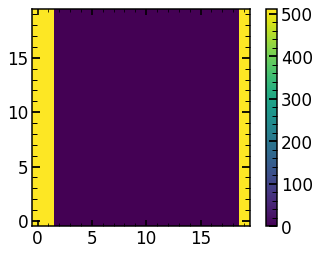

In [147]:
plt.imshow(var00_no_subtract_single_spot)
plt.colorbar()

In [152]:
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

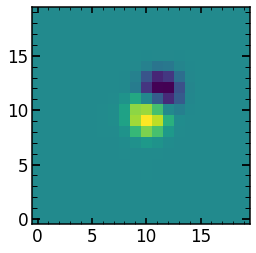

In [128]:
plt.imshow(data00_no_subtract_single_spot-optPsf_cut_fiber_convolved_downsampled)

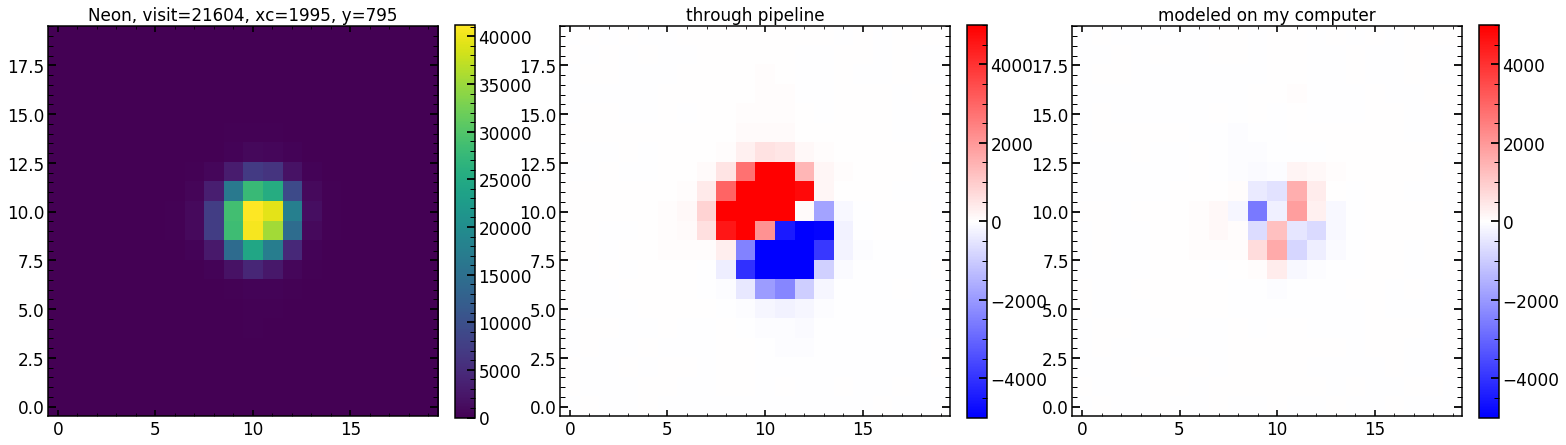

In [156]:
plt.figure(figsize=(26,12))
plt.subplot(131)
plt.imshow(data00_no_subtract_single_spot)
plt.title('Neon, visit=21604, xc=1995, y=795')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(data00_subtract_single_spot,cmap='bwr',vmax=5000,vmin=-5000)
plt.title('through pipeline')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(data00_no_subtract_single_spot-optPsf_cut_fiber_convolved_downsampled,cmap='bwr',vmax=5000,vmin=-5000)
plt.title('modeled on my computer')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

In [135]:
sci_image.shape

(20, 20)

# Argon data (PIPE2D-595) - broad lines

In [ ]:
def generate_1d(image):
    sample_1_0=np.sum(image[:,7:13][5:15],axis=1)
    sample_1_0=sample_1_0-np.min(sample_1_0)
    sample_1_0=sample_1_0/np.max(sample_1_0)
    return sample_1_0

from scipy.spatial import cKDTree
from scipy import interpolate

def upsample_coords(coord_list):
    # s is smoothness, set to zero
    # k is degree of the spline. setting to 1 for linear spline
    tck, u = interpolate.splprep(coord_list, k=1, s=0.0)
    upsampled_coords = interpolate.splev(np.linspace(0, 1, 400), tck)
    return upsampled_coords

def find_FWHM_and_1_values(LSF):
    LSF=LSF-np.min(LSF)
    LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
    max_value=np.max(LSF_upsampled[1])
    FWHM_position_2=(np.array(range(150,250))[(LSF_upsampled[1]>max_value/2)[150:250]])[-1]
    FWHM_position_1=(np.array(range(150,250))[(LSF_upsampled[1]>max_value/2)[150:250]])[0]
    
    print(FWHM_position_1,FWHM_position_2)
    
    FWHM_value=(FWHM_position_2-FWHM_position_1)/10
    
    FWHM_mean_position=np.mean([FWHM_position_1,FWHM_position_2])
    FWHM_extended_range=np.arange(FWHM_position_1-100,FWHM_position_2+100)
    percent_1_1=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][0]
    percent_1_2=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][-1]
    percent_1_value=(percent_1_2-percent_1_1)/10

    return [FWHM_mean_position,FWHM_value,percent_1_value]

In [ ]:
finalHgAr_May2019=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl',allow_pickle=True)
# the names of the fibers
list_of_fiber_IDs=list(np.unique(finalHgAr_May2019['fiber'].values))

image_index=55

In [ ]:
finalHgAr_May2019['wavelength']

In [ ]:
finalHgAr_May2019[finalHgAr_May2019['wavelength']=='912.5693']

In [ ]:
finalHgAr_May2019.loc[55]

In [ ]:
run=18940
image_index=55
scidata_cut_large_removed=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci"+\
                str(run)+str(image_index)+'Ar_Stacked_large.npy')

In [ ]:
"/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci"+\
                str(run)+str(image_index)+'Ar_Stacked_large.npy'

In [ ]:
'/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci18940'+str(index_image)+'Ar_Stacked_Large.npy'

In [ ]:
run_5=19238+54
image_index=69
sci_single_image_Ar=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci18940'+str(image_index)+'Ar_Stacked_Large.npy')
sci_single_image_HgAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked_Large.npy')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(sci_single_image_Ar,norm=LogNorm())
plt.subplot(122)
plt.imshow(sci_single_image_HgAr,norm=LogNorm())

In [ ]:
plt.figure(figsize=(24,6))
plt.subplot(121)
plt.plot(generate_1d(sci_single_image_Ar))
plt.plot(np.arange(1,1+10),generate_1d(sci_single_image_HgAr))
plt.subplot(122)

plt.plot(generate_1d(sci_single_image_Ar))
plt.plot(np.arange(1,11),generate_1d(sci_single_image_HgAr))

plt.ylim(0,0.1)

In [59]:
run_5=19238+54
res=[]
for index_image in [69,70,71]:

    sci_single_image_Ar=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci18940'+str(index_image)+'Ar_Stacked.npy')
    sci_single_image_HgAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')

    Ar_FWHM_15=find_FWHM_and_1_values(generate_1d(sci_single_image_Ar))
    HgAr_FWHM_15=find_FWHM_and_1_values(generate_1d(sci_single_image_HgAr))
    res.append(Ar_FWHM_15+HgAr_FWHM_15)

150 249
150 249
163 249
150 249
150 231
150 249


In [60]:
res

[[199.5, 9.9, 29.3, 199.5, 9.9, 29.8],
 [206.0, 8.6, 28.5, 199.5, 9.9, 29.8],
 [190.5, 8.1, 28.0, 199.5, 9.9, 29.8]]

In [54]:
Ar_FWHM_15

[199.5, 9.9, 29.3]

In [140]:
image_index=55
sci_single_image_HgAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')
finalHgAr_May2019.loc[55]

fiber                         339
xc                           1610
yc                           2334
wavelength               826.6699
close                         0.5
lamp                         HgAr
xc_effective                 1610
old_index_approx               79
superold_index_approx        42.0
Name: 55, dtype: object

## cutting on your own 

In [106]:
from astropy.io import fits

In [178]:
finalHgAr_May2019[finalHgAr_May2019['wavelength']=='826.6699'].index

Int64Index([7, 19, 31, 43, 55, 67, 79, 91, 103, 115], dtype='int64')

In [114]:
# set the dataframe used here 
finalHgAr=finalHgAr_May2019

# set up the numbers 
index_defocus=9
run=18940


DATA_FOLDER='/Volumes/Saturn_USA/PFS/ReducedData/May2020/neven_repo11_20200604b_subtract/'
data=fits.open(DATA_FOLDER+'v0'+str(run+0)+'/calExp-SA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  


list_of_sci_data=[]
list_of_var_data=[]
list_of_mask_data=[]
for run_i in range(10):
    data=fits.open(DATA_FOLDER+'v0'+str(run+run_i)+'/calExp-SA0'+str(run+run_i)+'r1.fits')
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
    #background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    #if run_i==0:
    #    print('background estimate is: '+str(background))

    #scidata_single=data[1].data-background
    scidata_single=data[1].data
    maskdata_single=data[2].data
    print('np.sum(maskdata_single)'+str(np.sum(maskdata_single)))
    vardata_single=data[3].data

    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

    list_of_sci_data.append(scidata_single)
    list_of_var_data.append(vardata_single)
    maskdata_single[np.isin(maskdata_single,[0,512])]=0
    maskdata_single[~np.isin(maskdata_single,[0,512])]=1
    list_of_mask_data.append(maskdata_single)

    



np.sum(maskdata_single)27624
np.sum(maskdata_single)26864
np.sum(maskdata_single)26056
np.sum(maskdata_single)23664
np.sum(maskdata_single)24240
np.sum(maskdata_single)27008
np.sum(maskdata_single)21808
np.sum(maskdata_single)25616
np.sum(maskdata_single)28384
np.sum(maskdata_single)28324


In [151]:
x_low_single=1538+70
x_high_single=1698-70
y_low_single=2218+105+1
y_high_single=2448-105+1
list_of_single_sci_data=[]
single_sci_data_stacked_Ar=np.zeros(list_of_sci_data[0].shape)
for i in range(10):
    list_of_single_sci_data.append(list_of_sci_data[i][y_low_single:y_high_single,x_low_single:x_high_single])    
    single_sci_data_stacked_Ar=+list_of_sci_data[i][y_low_single:y_high_single,x_low_single:x_high_single]

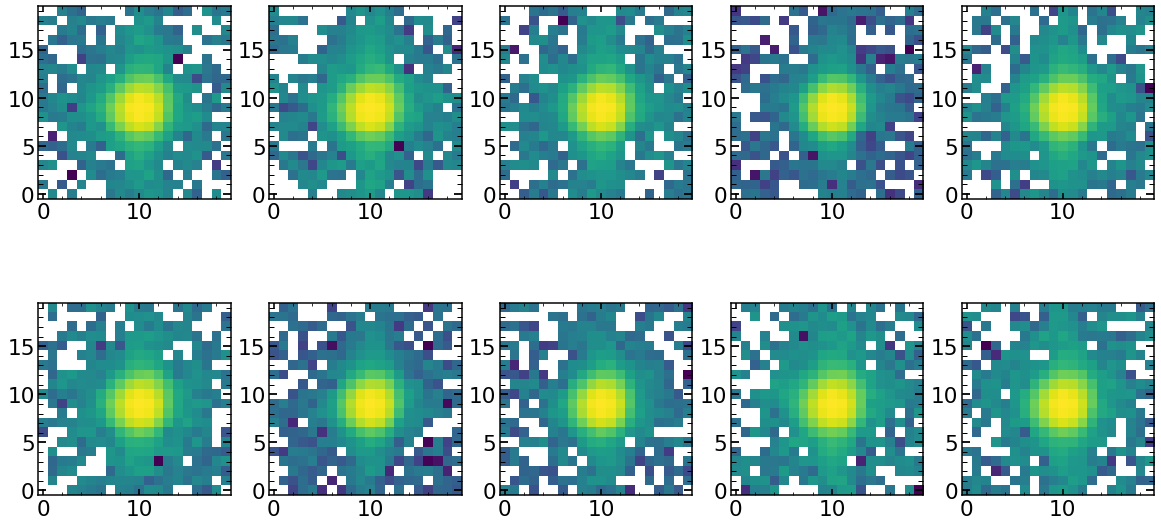

In [152]:
plt.figure(figsize=(20,10))
plt.subplot(2,5,1)
plt.imshow(list_of_single_sci_data[0],norm=LogNorm())
plt.subplot(2,5,2)
plt.imshow(list_of_single_sci_data[1],norm=LogNorm())
plt.subplot(2,5,3)
plt.imshow(list_of_single_sci_data[2],norm=LogNorm())
plt.subplot(2,5,4)
plt.imshow(list_of_single_sci_data[3],norm=LogNorm())
plt.subplot(2,5,5)
plt.imshow(list_of_single_sci_data[4],norm=LogNorm())
plt.subplot(2,5,6)
plt.imshow(list_of_single_sci_data[5],norm=LogNorm())
plt.subplot(2,5,7)
plt.imshow(list_of_single_sci_data[6],norm=LogNorm())
plt.subplot(2,5,8)
plt.imshow(list_of_single_sci_data[7],norm=LogNorm())
plt.subplot(2,5,9)
plt.imshow(list_of_single_sci_data[8],norm=LogNorm())
plt.subplot(2,5,10)
plt.imshow(list_of_single_sci_data[9],norm=LogNorm())

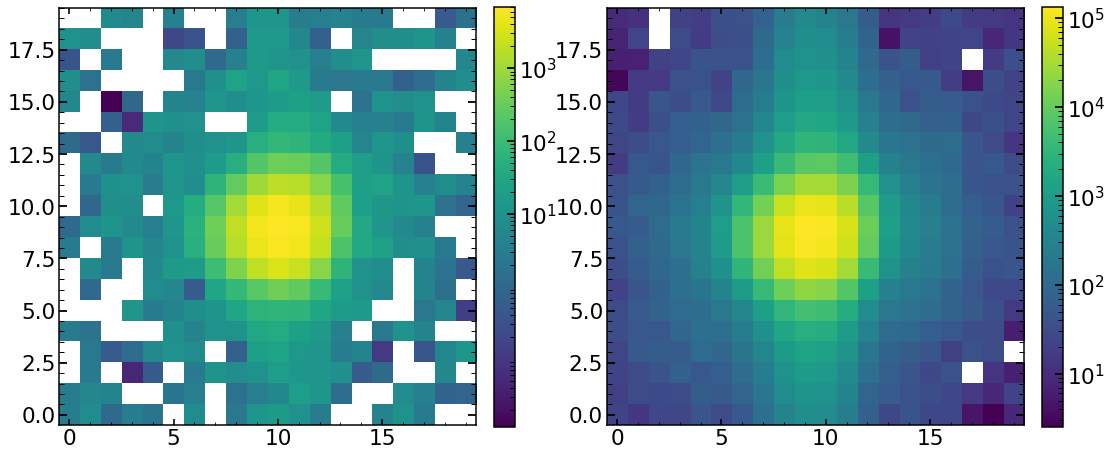

In [153]:
plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(single_sci_data_stacked_Ar,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(sci_single_image_HgAr,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

(0, 0.1)

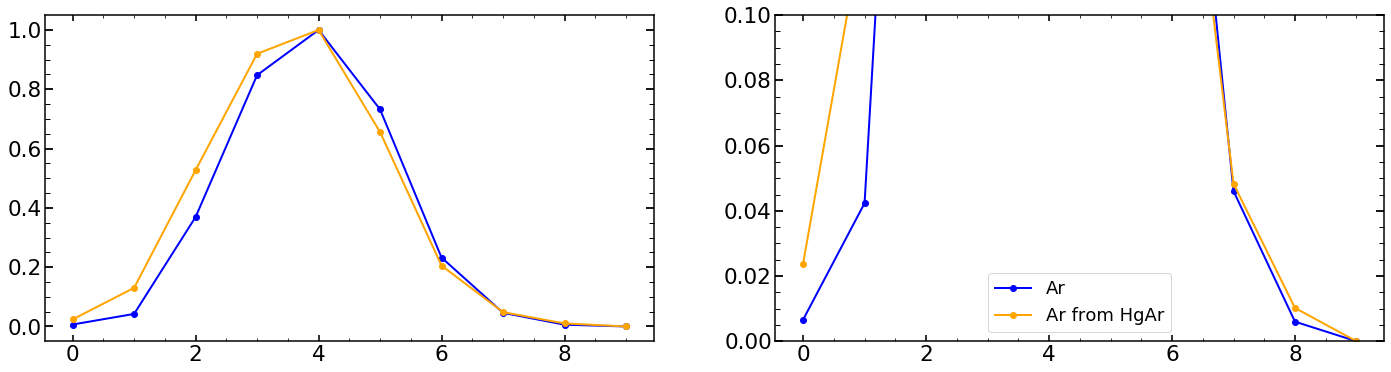

In [162]:
plt.figure(figsize=(24,6))
plt.subplot(121)
plt.plot(generate_1d(single_sci_data_stacked_Ar),color='blue',lw=2,marker='o',label='Ar')
plt.plot(np.arange(0,10),generate_1d(sci_single_image_HgAr),color='orange',lw=2,marker='o',label='Ar from HgAr')
plt.subplot(122)

plt.plot(generate_1d(single_sci_data_stacked_Ar),color='blue',lw=2,marker='o',label='Ar')
plt.plot(np.arange(0,10),generate_1d(sci_single_image_HgAr),color='orange',lw=2,marker='o',label='Ar from HgAr')

plt.legend()
plt.ylim(0,0.1)

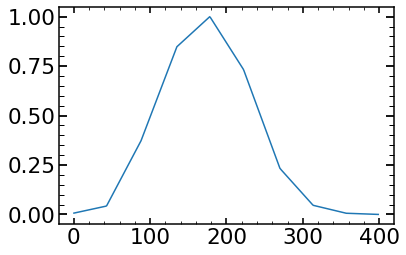

In [161]:
    LSF=generate_1d(single_sci_data_stacked_Ar)
    LSF=LSF-np.min(LSF)
    LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
    plt.plot(LSF_upsampled[1])

In [175]:
run=18940
image_index=69
scidata_cut_large_removed=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci"+\
                str(run)+str(image_index)+'Ar_Stacked_large.npy')

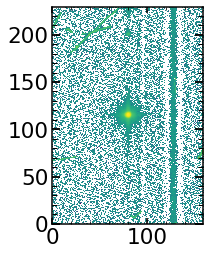

In [176]:
plt.imshow(scidata_cut_large_removed,norm=LogNorm())

In [186]:
run_5=19238+54
res=[]
for index_image in [7,31]:

    sci_single_image_Ar=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_12_2020/Stamp_cleaned/sci18940'+str(index_image)+'Ar_Stacked.npy')
    sci_single_image_HgAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')

    Ar_FWHM_15=find_FWHM_and_1_values(generate_1d(sci_single_image_Ar))
    HgAr_FWHM_15=find_FWHM_and_1_values(generate_1d(sci_single_image_HgAr))
    res.append(Ar_FWHM_15+HgAr_FWHM_15)

173 249
150 249
205 249
150 249


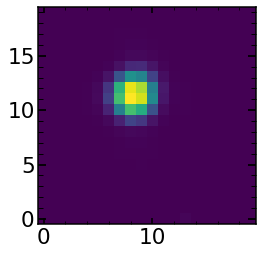

In [187]:
plt.imshow(sci_single_image_Ar)

In [ ]:
, 31, 43, 55, 67, 79, 91, 103, 115

## Testing Zernike_Cutting_module 

In [ ]:
import Zernike_Cutting_Module
from Zernike_Cutting_Module import *

In [196]:
Zernike_Cut=Zernike_Cutting_Module()

In [199]:
pfsDetectorMap=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/pfsDetectorMap-021604-r1.fits')

In [201]:
pfsDetectorMap[0].data

In [202]:
pfsDetectorMap[1].data

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 186, 187, 188, 189, 190, 191, 19

In [216]:
np.sum(pfsDetectorMap[2].data)

0.0

In [210]:
x_pfsDetectorMap=np.array(pfsDetectorMap[3].data)
y_pfsDetectorMap=np.array(pfsDetectorMap[4].data)

In [218]:
pfsDetectorMap[4].data

FITS_rec([(  0,    0., 620.8541 ), (  0,    1., 620.99786),
          (  0,    2., 621.1407 ), ..., (599, 4173., 975.379  ),
          (599, 4174., 975.4886 ), (599, 4175., 975.6    )],
         dtype=(numpy.record, [('index', '>i8'), ('knot', '>f4'), ('value', '>f4')]))

In [265]:
finalHgAr

,fiber,xc,yc,wavelength,close,lamp,xc_effective,old_index_approx,superold_index_approx
0,2,69,808,690.9346,0,HgAr,69,0,nan
1,2,69,875,696.7261,1,HgAr,69,1,90.0
2,2,70,992,706.8989,0,HgAr,70,2,nan
3,2,71,1229,727.47876,1,HgAr,71,3,nan
4,2,72,1358,738.6248,0,HgAr,72,4,80.0
...,...,...,...,...,...,...,...,...,...
115,650,4002,2379,826.6699,0.5,HgAr,4071,187,45.0
116,650,4003,2681,852.4029,0.5,HgAr,4072,188,35.0
117,650,4008,3393,912.5693,1,HgAr,4077,189,25.0
118,650,4009,3515,922.7301,0,HgAr,4078,190,15.0


In [264]:
fibers_10=np.unique(finalHgAr['fiber'].values)
wavelengths_HgAr=np.unique(finalHgAr['wavelength'].values)
close_HgAr=close_HgAr[0:len(wavelengths_HgAr)]

In [263]:
close_HgAr[0:len(wavelengths_HgAr)]

array(['0', '1', '0', '1', '0', 0.5, '1', 0.5, 0.5, '1', '0', '1'],
      dtype=object)

In [233]:
fibers_10=np.array([  2,  63, 192, 255, 339, 401, 464, 525, 587, 650])
for f in fibers_10:
    index_of_single_fiber=np.where(pfsDetectorMap[1].data==f)[0][0]

In [244]:
x_pfsDetectorMap_single_fiber=x_pfsDetectorMap[x_pfsDetectorMap['index']==index_of_single_fiber]
y_pfsDetectorMap_single_fiber=y_pfsDetectorMap[y_pfsDetectorMap['index']==index_of_single_fiber]

In [240]:
y_pfsDetectorMap['index']

array([  0,   0,   0, ..., 599, 599, 599])

In [257]:
y_value_single_fiber_single_wavelength=\
int(y_pfsDetectorMap_single_fiber['knot'][np.where(y_pfsDetectorMap_single_fiber['value']==find_nearest(y_pfsDetectorMap_single_fiber['value'],690.9346))[0][0]])
x_value_single_fiber_single_wavelength=\
int(x_pfsDetectorMap_single_fiber['knot'][np.where(x_pfsDetectorMap_single_fiber['value']==find_nearest(x_pfsDetectorMap_single_fiber['value'],690.9346))[0][0]])

In [245]:
y_pfsDetectorMap_single_fiber['value']

array([621.0099 , 621.15295, 621.2948 , ..., 975.379  , 975.4886 ,
       975.6    ], dtype=float32)

In [392]:
int(x_pfsDetectorMap_single_fiber['knot'][np.where(x_pfsDetectorMap_single_fiber['value']==\
find_nearest(x_pfsDetectorMap_single_fiber['value'],float(wavelengths_HgAr[np.mod(i,len(fibers_10))])))[0][0]])
    

1941

In [391]:
int(x_pfsDetectorMap_single_fiber['knot'][np.where(y_pfsDetectorMap_single_fiber['value']==\
                                                                                    find_nearest(y_pfsDetectorMap_single_fiber['value'],float(wavelengths_HgAr[np.mod(i,len(fibers_10))])))[0][0]])
    

3472

In [394]:
x_pfsDetectorMap_single_fiber

array([(599,   80., 61.372887), (599,   81., 61.3869  ),
       (599,   82., 61.400627), ..., (599, 4120., 57.72416 ),
       (599, 4121., 57.7084  ), (599, 4122., 57.692497)],
      dtype=(numpy.record, [('index', '>i8'), ('knot', '>f4'), ('value', '>f4')]))

In [395]:
y_pfsDetectorMap_single_fiber

array([(599,    0., 621.0099 ), (599,    1., 621.15295),
       (599,    2., 621.2948 ), ..., (599, 4173., 975.379  ),
       (599, 4174., 975.4886 ), (599, 4175., 975.6    )],
      dtype=(numpy.record, [('index', '>i8'), ('knot', '>f4'), ('value', '>f4')]))

In [435]:
wavelengths_HgAr

array(['690.9346', '696.7261', '706.8989', '727.47876', '738.6248',
       '763.74286', '795.0522', '826.6699', '852.4029', '912.5693',
       '922.7301', '966.0642'], dtype=object)

In [436]:
close_HgAr

array(['0', '1', '0', '1', '0', 0.5, '1', 0.5, 0.5, '1', '0', '1'],
      dtype=object)

In [431]:
fibers_10=np.unique(finalHgAr['fiber'].values)
wavelengths_HgAr=np.unique(finalHgAr['wavelength'].values)
close_HgAr=close_HgAr[0:len(wavelengths_HgAr)]

second_offset=finalHgAr_Feb2020_dataset['second_offset'][0:len(wavelengths_HgAr)].values
second_flux=finalHgAr_Feb2020_dataset['second_ratio'][0:len(wavelengths_HgAr)].values

second2_offset=finalHgAr_Feb2020_dataset['second2_offset'][0:len(wavelengths_HgAr)].values
second2_flux=finalHgAr_Feb2020_dataset['second2_ratio'][0:len(wavelengths_HgAr)].values

In [441]:
second2_flux

array([0.006, 0, 0.088, 0, 0, 0, 0, 0, 0, 0, 0.011, 0], dtype=object)

In [432]:
fibers_10=np.array([  2,  63, 192, 255, 339, 401, 464, 525, 587, 650])
for f in fibers_10:
    index_of_single_fiber=np.where(pfsDetectorMap[1].data==f)[0][0]

columns_for_df=['fiber','xc','yc','wavelength','close','lamp','xc_effective','second_offset','second_flux','second2_offset','second2_flux']
data=np.zeros((len(fibers_10)*len(wavelengths_HgAr),len(columns_for_df)))

Zernike_info_df = pd.DataFrame(data, index=range(len(fibers_10)*len(wavelengths_HgAr)), columns=columns_for_df)

list_of_acutal_fibers=[]
list_of_yc=[]
list_of_xc=[]
list_of_xc_eff=[]
list_of_wavelength=[]
list_of_close=[]
list_of_lamp=[]
list_of_second_offset=[]
list_of_second_ratio=[]
list_of_second2_offset=[]
list_of_second2_ratio=[]

for i in range(len(fibers_10)*len(wavelengths_HgAr)):
    
    # fiber index, sequenetial as they appear on the detector, i.e., starting at 0 and going +1
    index_of_single_fiber_sequential=int(np.floor(i/len(wavelengths_HgAr)))
    # actual number of the fiber (i.e., going up to 650)
    actual_fiber=int(fibers_10[index_of_single_fiber_sequential])
    # index of a fiber, as they go through the detectorMap (i.e., going up to 599)
    index_of_single_fiber=np.where(pfsDetectorMap[1].data==actual_fiber)[0][0]

    
    # add the information about the actual fiber in the dataframe
    Zernike_info_df.loc[i]['fiber']=actual_fiber
    list_of_acutal_fibers.append(actual_fiber)
    
    # select the parts of the detectorMap which correspond to that particular fiber
    x_pfsDetectorMap_single_fiber=x_pfsDetectorMap[x_pfsDetectorMap['index']==index_of_single_fiber]
    y_pfsDetectorMap_single_fiber=y_pfsDetectorMap[y_pfsDetectorMap['index']==index_of_single_fiber]
    
    # first find the y position
    #Zernike_info_df.loc[i]['yc']=int(x_pfsDetectorMap_single_fiber['knot'][np.where(y_pfsDetectorMap_single_fiber['value']==\
    #                                                                                find_nearest(y_pfsDetectorMap_single_fiber['value'],float(wavelengths_HgAr[np.mod(i,len(fibers_10))])))[0][0]])
    
    y_value=int(x_pfsDetectorMap_single_fiber['knot'][np.where(y_pfsDetectorMap_single_fiber['value']==\
            find_nearest(y_pfsDetectorMap_single_fiber['value'],float(wavelengths_HgAr[np.mod(i,len(fibers_10))])))[0][0]])
    x_value=int(x_pfsDetectorMap_single_fiber['value'][np.where(x_pfsDetectorMap_single_fiber['knot']==y_value)])
    
    if x_value>2048:
        x_value_eff=x_value+69
    else:
        x_value_eff=x_value
    
    list_of_yc.append(y_value)
    
    # from y position, deduce x position
    #Zernike_info_df.loc[i]['xc']=int(x_pfsDetectorMap_single_fiber['value'][np.where(x_pfsDetectorMap_single_fiber['knot']==Zernike_info_df.loc[i]['yc'])])
    list_of_xc.append(x_value)
    
    list_of_xc_eff.append(x_value_eff)
    
    #Zernike_info_df.loc[i]['wavelength']=wavelengths_HgAr[np.mod(i,len(fibers_10))]
    list_of_wavelength.append(wavelengths_HgAr[np.mod(i,len(wavelengths_HgAr))])
    #Zernike_info_df.loc[i]['close']=close_HgAr[np.mod(i,len(fibers_10))]
    list_of_close.append(close_HgAr[np.mod(i,len(wavelengths_HgAr))])
    #Zernike_info_df.loc[i]['lamp']='HgAr'
    list_of_lamp.append('HgAr')
    
    #Zernike_info_df.loc[i]['second_offset']=second_offset[np.mod(i,len(fibers_10))]
    list_of_second_offset.append(second_offset[np.mod(i,len(wavelengths_HgAr))])
    #Zernike_info_df.loc[i]['second_flux']=second_flux[np.mod(i,len(fibers_10))]
    list_of_second_ratio.append(second_flux[np.mod(i,len(wavelengths_HgAr))])
    #Zernike_info_df.loc[i]['second2_offset']=second2_offset[np.mod(i,len(fibers_10))]
    list_of_second2_offset.append(second2_offset[np.mod(i,len(wavelengths_HgAr))])
    #Zernike_info_df.loc[i]['second2_flux']=second2_flux[np.mod(i,len(fibers_10))]
    list_of_second2_ratio.append(second2_flux[np.mod(i,len(wavelengths_HgAr))])    
    
    

#for i in range(len(fibers_10)*len(wavelengths_HgAr)):
#    if Zernike_info_df.loc[i]['xc']<2048:
#        Zernike_info_df.loc[i]['xc_effective']=Zernike_info_df.loc[i]['xc']
#    else:
#        Zernike_info_df.loc[i]['xc_effective']=Zernike_info_df.loc[i]['xc']+69


Zernike_info_df=pd.DataFrame({'fiber':list_of_acutal_fibers,'xc':list_of_xc,'yc':list_of_yc,'wavelength':list_of_wavelength,'close':list_of_close,\
                                     'lamp':list_of_lamp,'xc_effective':list_of_xc_eff,'second_offset':list_of_second_offset,'second_ratio':list_of_second_ratio,\
                                      'second2_offset':list_of_second2_offset, 'second2_ratio':list_of_second2_ratio})

#finalHgAr_Feb2020_dataset.to_pickle("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020")

In [427]:
second_offset

array([-19.25, 0, 16.93, 0, -13.14, -38.59, 0, 18.83, -14.26, 0],
      dtype=object)

In [433]:
Zernike_info_df

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,4005,917,690.9346,0,HgAr,4074,-19.25,0.0034,-40.70,0.006
1,2,4005,984,696.7261,1,HgAr,4074,0.00,0.0000,0.00,0.000
2,2,4004,1101,706.8989,0,HgAr,4073,16.93,0.2680,28.33,0.088
3,2,4003,1337,727.47876,1,HgAr,4072,0.00,0.0000,0.00,0.000
4,2,4003,1465,738.6248,0,HgAr,4072,-13.14,0.0110,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...
115,650,73,1727,826.6699,0.5,HgAr,73,18.83,0.0043,0.00,0.000
116,650,73,2090,852.4029,0.5,HgAr,73,-14.26,0.0150,0.00,0.000
117,650,72,2458,912.5693,1,HgAr,72,0.00,0.0000,0.00,0.000
118,650,71,2759,922.7301,0,HgAr,71,22.44,0.0220,-13.14,0.011


In [434]:
finalHgAr_Feb2020_dataset

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,69,808,690.9346,0,HgAr,69,-19.25,0.0034,-40.7,0.006
1,2,69,875,696.7261,1,HgAr,69,0,0,0,0
2,2,70,992,706.8989,0,HgAr,70,16.93,0.268,28.33,0.088
3,2,71,1229,727.47876,1,HgAr,71,0,0,0,0
4,2,72,1358,738.6248,0,HgAr,72,-13.14,0.011,0,0
...,...,...,...,...,...,...,...,...,...,...,...
115,650,4002,2379,826.6699,0.5,HgAr,4071,18.83,0.0043,0,0
116,650,4003,2681,852.4029,0.5,HgAr,4072,-14.26,0.015,0,0
117,650,4008,3393,912.5693,1,HgAr,4077,0,0,0,0
118,650,4009,3515,922.7301,0,HgAr,4078,22.44,0.022,-13.14,0.011


In [303]:
finalHgAr

,fiber,xc,yc,wavelength,close,lamp,xc_effective,old_index_approx,superold_index_approx
0,2,69,808,690.9346,0,HgAr,69,0,nan
1,2,69,875,696.7261,1,HgAr,69,1,90.0
2,2,70,992,706.8989,0,HgAr,70,2,nan
3,2,71,1229,727.47876,1,HgAr,71,3,nan
4,2,72,1358,738.6248,0,HgAr,72,4,80.0
...,...,...,...,...,...,...,...,...,...
115,650,4002,2379,826.6699,0.5,HgAr,4071,187,45.0
116,650,4003,2681,852.4029,0.5,HgAr,4072,188,35.0
117,650,4008,3393,912.5693,1,HgAr,4077,189,25.0
118,650,4009,3515,922.7301,0,HgAr,4078,190,15.0


In [307]:
finalNe

NameError: name 'finalNe' is not defined

In [285]:
np.mod(i,len(fibers_10))

0

In [287]:
Zernike_info_df.loc[0]['fiber']

0.0

In [284]:
for i in range(5):
    Zernike_info_df[i]['fiber']=np.mod(i,len(fibers_10))

KeyError: 0

In [281]:
np.mod(11,10)

1

In [453]:
Zernike_info_df

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,4005,917,690.9346,0,HgAr,4074,-19.25,0.0034,-40.70,0.006
1,2,4005,984,696.7261,1,HgAr,4074,0.00,0.0000,0.00,0.000
2,2,4004,1101,706.8989,0,HgAr,4073,16.93,0.2680,28.33,0.088
3,2,4003,1337,727.47876,1,HgAr,4072,0.00,0.0000,0.00,0.000
4,2,4003,1465,738.6248,0,HgAr,4072,-13.14,0.0110,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...
115,650,73,1727,826.6699,0.5,HgAr,73,18.83,0.0043,0.00,0.000
116,650,73,2090,852.4029,0.5,HgAr,73,-14.26,0.0150,0.00,0.000
117,650,72,2458,912.5693,1,HgAr,72,0.00,0.0000,0.00,0.000
118,650,71,2759,922.7301,0,HgAr,71,22.44,0.0220,-13.14,0.011


In [308]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f) 

In [310]:
4085-4016

69

In [454]:
finalHgAr_Feb2020_dataset

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,69,808,690.9346,0,HgAr,69,-19.25,0.0034,-40.7,0.006
1,2,69,875,696.7261,1,HgAr,69,0,0,0,0
2,2,70,992,706.8989,0,HgAr,70,16.93,0.268,28.33,0.088
3,2,71,1229,727.47876,1,HgAr,71,0,0,0,0
4,2,72,1358,738.6248,0,HgAr,72,-13.14,0.011,0,0
...,...,...,...,...,...,...,...,...,...,...,...
115,650,4002,2379,826.6699,0.5,HgAr,4071,18.83,0.0043,0,0
116,650,4003,2681,852.4029,0.5,HgAr,4072,-14.26,0.015,0,0
117,650,4008,3393,912.5693,1,HgAr,4077,0,0,0,0
118,650,4009,3515,922.7301,0,HgAr,4078,22.44,0.022,-13.14,0.011


In [315]:
finalHgAr_Feb2020_dataset['second_offset'][0:len(fibers_10)].values

array([-19.25, 0, 16.93, 0, -13.14, -38.59, 0, 18.83, -14.26, 0],
      dtype=object)

In [317]:
finalHgAr_Feb2020_dataset['second_ratio'][0:len(fibers_10)].values

array([0.0034, 0, 0.268, 0, 0.011, 0.008, 0, 0.0043, 0.015, 0],
      dtype=object)

In [318]:
finalHgAr_Feb2020_dataset['second2_offset'][0:len(fibers_10)].values

array([-40.7, 0, 28.33, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [319]:
finalHgAr_Feb2020_dataset['second2_ratio'][0:len(fibers_10)].values

array([0.006, 0, 0.088, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [443]:
finalNe_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020",allow_pickle=True)

In [451]:
finalNe_Kr2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [447]:
fibers_10=np.unique(finalHgAr['fiber'].values)
wavelengths_HgAr=np.unique(finalNe_Feb2020_dataset['wavelength'].values)
print(wavelengths_HgAr)
close_HgAr=finalNe_Feb2020_dataset['close'].values[0:len(wavelengths_HgAr)]
print(close_HgAr)


second_offset=finalNe_Feb2020_dataset['second_offset'][0:len(wavelengths_HgAr)].values
second_flux=finalNe_Feb2020_dataset['second_ratio'][0:len(wavelengths_HgAr)].values

second2_offset=finalNe_Feb2020_dataset['second2_offset'][0:len(wavelengths_HgAr)].values
second2_flux=finalNe_Feb2020_dataset['second2_ratio'][0:len(wavelengths_HgAr)].values

print(second_offset)
print(second_flux)
print(second2_offset)
print(second2_flux)

['650.84186' '653.4774' '660.0668' '668.01764' '671.9268' '693.13116'
 '717.59015' '724.72437' '744.1276']
['0' '-1' '1' '0' '-1' '1' '1' '1' '0']
[30.12 0 0 44.24 0 0 0 0 38.57]
[0.406 0 0 0.67 0 0 0 0 0.012]
[0 0 0 -29.97 0 0 0 0 57.44]
[0 0 0 0.003 0 0 0 0 0.162]


In [452]:
fibers_10=np.unique(finalHgAr['fiber'].values)
wavelengths_HgAr=np.unique(finalNe_Kr2020_dataset['wavelength'].values)
print(wavelengths_HgAr)
close_HgAr=finalNe_Kr2020_dataset['close'].values[0:len(wavelengths_HgAr)]
print(close_HgAr)


second_offset=finalNe_Kr2020_dataset['second_offset'][0:len(wavelengths_HgAr)].values
second_flux=finalNe_Kr2020_dataset['second_ratio'][0:len(wavelengths_HgAr)].values

second2_offset=finalNe_Kr2020_dataset['second2_offset'][0:len(wavelengths_HgAr)].values
second2_flux=finalNe_Kr2020_dataset['second2_ratio'][0:len(wavelengths_HgAr)].values

print(second_offset)
print(second_flux)
print(second2_offset)
print(second2_flux)

[785.48 819.0 877.68 892.87]
[0 0 0 1]
[8 20 -15 0]
[0.01 0.004 0.004 0]
[0 0 10 0]
[0 0 0.003 0]


In [ ]:
plt.figure(figsize=(11,11))

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[0][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, leftmost fiber',color='red')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[1][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, rightmost fiber',color='orange')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[2][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, shortest wav. (690.93 nm)',color='darkviolet')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[3][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, longest wav. (966.06 nm)',color='blue')

plt.errorbar(x=pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,0],y=pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,3],\
             xerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,1:3]),yerr=np.transpose(pos_4_pp_Subaru_May_2019_quantiles_9_i[4][:,4:6]),\
             elinewidth=3,ls='',marker='o',capsize=2,label='Subaru, May 1, 2020, central part',color='black')


plt.axes().set_aspect('equal', 'datalim')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.axhline(-0.5,color='gray',ls='--')
plt.axhline(0,color='gray',ls='--')
plt.axhline(+0.5,color='gray',ls='--')

plt.axvline(-0.5,color='gray',ls='--')
plt.axvline(0,color='gray',ls='--')
plt.axvline(0.5,color='gray',ls='--')


plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.xlabel('Delta x pixels')
plt.ylabel('Delta y pixels')

# Argon data (PIPE2D-595) - again, but with the cutting Module

## code 

In [170]:
# optimazed for non-dithered images here 

def generate_1d(image):
    
    rounded_center=np.round([find_centroid_of_flux(sci_image)])[0]
    print('centered coordinate is '+str(rounded_center))
    # you can fail here if psf is not centered
    sample_1_0=np.sum(image[int(rounded_center[1])-5:int(rounded_center[1])+5,int(rounded_center[0])-3:int(rounded_center[0])+3],axis=1)
    sample_1_0=sample_1_0-np.min(sample_1_0)
    sample_1_0=sample_1_0/np.max(sample_1_0)
    return sample_1_0

from scipy.spatial import cKDTree
from scipy import interpolate

def upsample_coords(coord_list):
    # s is smoothness, set to zero
    # k is degree of the spline. setting to 1 for linear spline
    tck, u = interpolate.splprep(coord_list, k=1, s=0.0)
    upsampled_coords = interpolate.splev(np.linspace(0, 1, 400), tck)
    return upsampled_coords

def find_FWHM_and_1_values(LSF):
    LSF=LSF-np.min(LSF)
    LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
    max_value=np.max(LSF_upsampled[1])
    FWHM_position_2=(np.array(range(100,300))[(LSF_upsampled[1]>max_value/2)[100:300]])[-1]
    FWHM_position_1=(np.array(range(100,300))[(LSF_upsampled[1]>max_value/2)[100:300]])[0]
    
    print('FWHM positions in upsampled:' + str([FWHM_position_1,FWHM_position_2]))
    
    FWHM_value=(FWHM_position_2-FWHM_position_1)/40
    
    FWHM_mean_position=np.mean([FWHM_position_1,FWHM_position_2])
    FWHM_extended_range=np.arange(FWHM_position_1-100,FWHM_position_2+100)
    percent_1_1=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][0]
    percent_1_2=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][-1]
    
    percent_1_position_1=(np.array(range(0,400))[(LSF_upsampled[1]>0.015)[0:400]])[0]
    percent_1_position_2=(np.array(range(0,400))[(LSF_upsampled[1]>0.015)[0:400]])[-1]    

    print('1.5% positions in upsampled:' + str([percent_1_position_1,percent_1_position_2]))
     
    percent_1_value=(percent_1_2-percent_1_1)/40

    
    
    return [FWHM_mean_position,FWHM_value,percent_1_value,FWHM_position_1,FWHM_position_2,percent_1_position_1,percent_1_position_2]

## Cutting Argon 

In [59]:
# import the pfsDetectorMap
DATA_FOLDER_FOR_pfsDetectorMap='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/'
pfsDetectorMap=fits.open(DATA_FOLDER_FOR_pfsDetectorMap+'pfsDetectorMap-021604-r1.fits')
arc='Ar'
DATA_FOLDER_FOR_poststamps='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/'
visit_0='018940'

# creates the pandas dataframe Zernike_info_df, which we will use for cutting the data
# inputs are:
# 1. DetectorMap, 2. arc used, 3. where to export created poststamps, 4. the visit name of the input 
create_Zernike_info_df(pfsDetectorMap,arc,DATA_FOLDER_FOR_poststamps,visit_0)

Zernike_info_df_Ar_021604=np.load(DATA_FOLDER_FOR_poststamps+'Dataframes/Zernike_info_df_'+arc+'_'+visit_0,allow_pickle=True)

In [60]:
DATA_FOLDER_FOR_detrended_data='/Volumes/Saturn_USA 1/PFS/ReducedData/May2020/neven_repo11_20200604b_subtract/'

# first number of the visit
run_0=18940
# number of images per a single configuration
number_of_images=10
# Subaru (SUB) or LAM
SUB_LAM='SUB'
#should we subtract continuum
subtract_continuum=False
# dither (either None, or 4 or 9)
dither=None
# verbosity setting (0=no output, 1=full output)
verbosity=1
# save the outputs
save=True
# use_previous_full_stacked_images if they have been made - if you are rerunning this routine this will make it go quicker
# by reusing previously stacked images
use_previous_full_stacked_images=True


Zernike_cutting_Jun_2020=Zernike_cutting(DATA_FOLDER=DATA_FOLDER_FOR_detrended_data,run_0=run_0,number_of_images=number_of_images,SUB_LAM=SUB_LAM,\
                                  subtract_continuum=subtract_continuum,Zernike_info_df=Zernike_info_df_Ar_021604,dither=dither,\
                                            verbosity=verbosity,save=True,use_previous_full_stacked_images=use_previous_full_stacked_images)

Zernike_cutting_Jun_2020.create_poststamps()

Using previously created full images, because they exist and use_previous_full_stacked_images==True
Loading from: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/scidata18940Ar_Stacked.npy


  0%|                                                                                                        | 0/120 [00:00<?, ?it/s]/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 18%|█████████████████▏                                                                            | 22/120 [00:00<00:00, 213.39it/s]

Successfully stacked images
exposure_arc is Ar
exposure_defocus is 0.0
dithering is None
exposure_defocus is 0.0: Central position of the spot 0 is: [69, 809]
iteration nr. 0: [799, 819, 59, 79]
cannot convert float NaN to integer
image with index 0 failed
######################################################
exposure_defocus is 0.0: Central position of the spot 1 is: [70, 876]
iteration nr. 0: [866, 886, 60, 80]
iteration nr. 1: [864, 884, 65, 85]
iteration nr. 2: [864, 884, 64, 84]
iteration nr. 3: [864, 884, 64, 84]
initial cut for image_index 1 - xposmin,xposmax,yposmin,yposmax: [1, 154, 759, 989]
y_x_lower_upper positions in the final cut: [5, 25, 17, 37]
image with index 1 seems successful
saving at: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci189401Ar_Stacked.npy
######################################################
exposure_defocus is 0.0: Central position of the spot 2 is: [70, 993]
iteration nr. 0: [983, 1003, 60, 80]
iteration nr. 1: [981

 52%|█████████████████████████████████████████████████▎                                            | 63/120 [00:00<00:00, 204.80it/s]


iteration nr. 0: [1600, 1620, 1213, 1233]
iteration nr. 1: [1601, 1621, 1217, 1237]
iteration nr. 2: [1601, 1621, 1218, 1238]
iteration nr. 3: [1601, 1621, 1218, 1238]
initial cut for image_index 41 - xposmin,xposmax,yposmin,yposmax: [1148, 1308, 1496, 1726]
y_x_lower_upper positions in the final cut: [5, 25, 20, 40]
image with index 41 seems successful
saving at: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci1894041Ar_Stacked.npy
######################################################
exposure_defocus is 0.0: Central position of the spot 42 is: [1223, 1971]
iteration nr. 0: [1961, 1981, 1213, 1233]
iteration nr. 1: [1962, 1982, 1219, 1239]
iteration nr. 2: [1962, 1982, 1218, 1238]
iteration nr. 3: [1962, 1982, 1218, 1238]
initial cut for image_index 42 - xposmin,xposmax,yposmin,yposmax: [1148, 1308, 1857, 2087]
y_x_lower_upper positions in the final cut: [5, 25, 20, 40]
image with index 42 seems successful
saving at: /Users/nevencaplar/Documents/PFS/Re

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 205.32it/s]


image with index 82 seems successful
saving at: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci1894082Ar_Stacked.npy
######################################################
exposure_defocus is 0.0: Central position of the spot 83 is: [2440, 3981]
iteration nr. 0: [3971, 3991, 2430, 2450]
iteration nr. 1: [3969, 3989, 2436, 2456]
iteration nr. 2: [3970, 3990, 2436, 2456]
iteration nr. 3: [3970, 3990, 2436, 2456]
initial cut for image_index 83 - xposmin,xposmax,yposmin,yposmax: [2366, 2526, 3865, 4095]
y_x_lower_upper positions in the final cut: [5, 25, 20, 40]
image with index 83 seems successful
saving at: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci1894083Ar_Stacked.npy
######################################################
exposure_defocus is 0.0: Central position of the spot 84 is: [2829, 776]
iteration nr. 0: [766, 786, 2819, 2839]
cannot convert float NaN to integer
image with index 84 failed
######################

In [ ]:
# line at 690, that should be Hg, how does that look
# in next section I see that all of these failed, as it should have happened

In [322]:
Zernike_info_df_Ar_021604[Zernike_info_df_Ar_021604['wavelength']=='690.9346']

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,650,69,809,690.9346,0,Ar,69,-19.25,0.0034,-40.7,0.006
12,587,461,795,690.9346,0,Ar,461,-19.25,0.0034,-40.7,0.006
24,525,845,785,690.9346,0,Ar,845,-19.25,0.0034,-40.7,0.006
36,464,1222,777,690.9346,0,Ar,1222,-19.25,0.0034,-40.7,0.006
48,401,1610,772,690.9346,0,Ar,1610,-19.25,0.0034,-40.7,0.006
60,339,1992,771,690.9346,0,Ar,1992,-19.25,0.0034,-40.7,0.006
72,255,2441,771,690.9346,0,Ar,2510,-19.25,0.0034,-40.7,0.006
84,192,2829,776,690.9346,0,Ar,2898,-19.25,0.0034,-40.7,0.006
96,63,3626,796,690.9346,0,Ar,3695,-19.25,0.0034,-40.7,0.006
108,2,4006,810,690.9346,0,Ar,4075,-19.25,0.0034,-40.7,0.006


## comparing HgAr to Ar

### Argon 

In [328]:
single_index=49

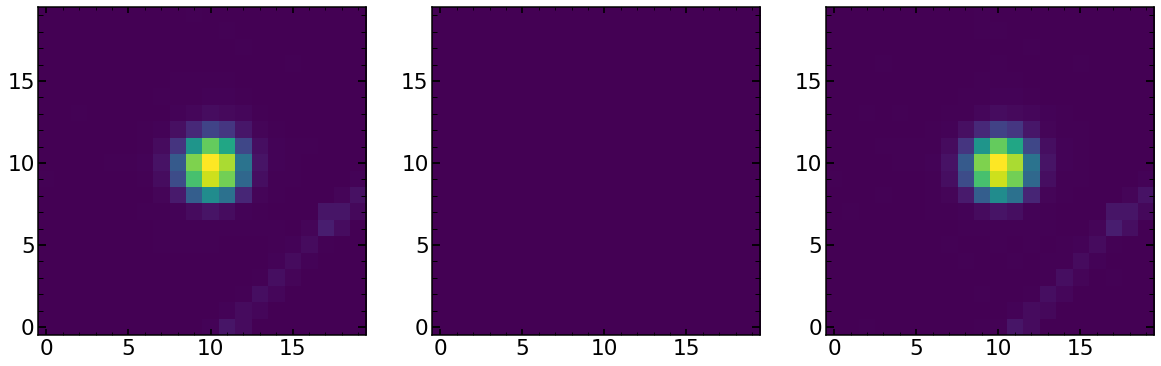

In [329]:
plt.figure(figsize=(20,10))
plt.subplot(131)
sci_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci18940'+str(single_index)+'Ar_Stacked.npy')
plt.imshow(sci_image)

plt.subplot(132)
mask_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/mask18940'+str(single_index)+'Ar_Stacked.npy')
plt.imshow(mask_image)

plt.subplot(133)
var_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/var18940'+str(single_index)+'Ar_Stacked.npy')
plt.imshow(var_image)

centered coordinate is [11. 10.]
FWHM positions in upsampled:[100, 241]
1.5% positions in upsampled:[4, 313]


(0, 0.02)

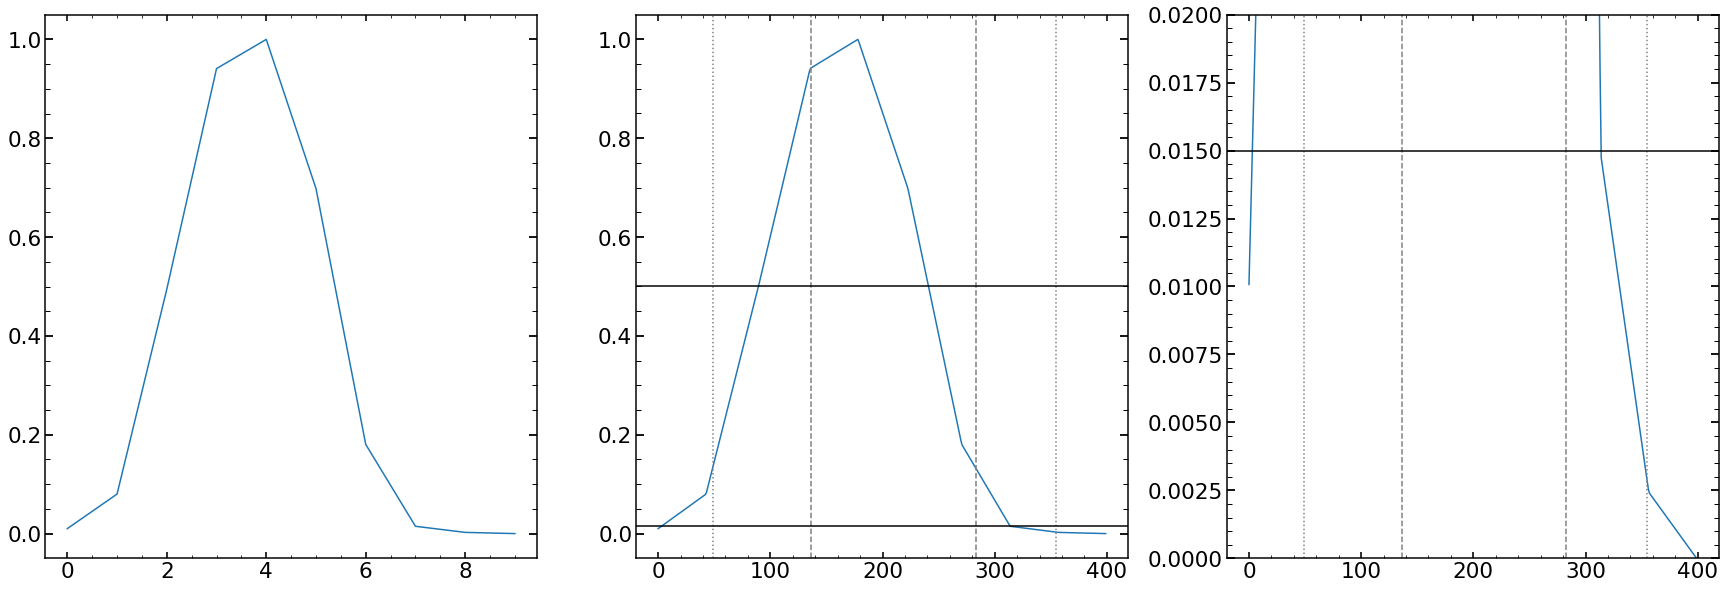

In [138]:
LSF=generate_1d(sci_image)
#plt.plot(LSF)
LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
find_FWHM_and_1_values(LSF)

plt.figure(figsize=(30,10))

plt.subplot(131)
plt.plot(LSF)

plt.subplot(132)
plt.plot(LSF_upsampled[1])
plt.axvline(136,color='gray',ls='--')
plt.axvline(283,color='gray',ls='--')

plt.axvline(49,color='gray',ls=':')
plt.axvline(355,color='gray',ls=':')
plt.axhline(0.015,color='black')
plt.axhline(0.5,color='black')

plt.subplot(133)
plt.plot(LSF_upsampled[1])
plt.axvline(136,color='gray',ls='--')
plt.axvline(283,color='gray',ls='--')

plt.axvline(49,color='gray',ls=':')
plt.axvline(355,color='gray',ls=':')

plt.axhline(0.015,color='black')

plt.ylim(0,0.02)

In [139]:
LSF_upsampled

[array([0.        , 0.02341687, 0.04683374, 0.07025062, 0.09366749,
        0.11708436, 0.14050123, 0.1639181 , 0.18733497, 0.21075185,
        0.23416872, 0.25758559, 0.28100246, 0.30441933, 0.3278362 ,
        0.35125308, 0.37466995, 0.39808682, 0.42150369, 0.44492056,
        0.46833743, 0.49175431, 0.51517118, 0.53858805, 0.56200492,
        0.58542179, 0.60883866, 0.63225554, 0.65567241, 0.67908928,
        0.70250615, 0.72592302, 0.7493399 , 0.77275677, 0.79617364,
        0.81959051, 0.84300738, 0.86642425, 0.88984113, 0.913258  ,
        0.93667487, 0.96009174, 0.98350861, 1.0064132 , 1.02809791,
        1.04978261, 1.07146732, 1.09315203, 1.11483674, 1.13652144,
        1.15820615, 1.17989086, 1.20157556, 1.22326027, 1.24494498,
        1.26662968, 1.28831439, 1.3099991 , 1.3316838 , 1.35336851,
        1.37505322, 1.39673792, 1.41842263, 1.44010734, 1.46179205,
        1.48347675, 1.50516146, 1.52684617, 1.54853087, 1.57021558,
        1.59190029, 1.61358499, 1.6352697 , 1.65

In [140]:
    
    LSF=LSF-np.min(LSF)
    LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
    max_value=np.max(LSF_upsampled[1])
    FWHM_position_2=(np.array(range(150,250))[(LSF_upsampled[1]>max_value/2)[150:250]])[-1]
    FWHM_position_1=(np.array(range(150,250))[(LSF_upsampled[1]>max_value/2)[150:250]])[0]
    
    print(FWHM_position_1,FWHM_position_2)
    
    FWHM_value=(FWHM_position_2-FWHM_position_1)/10
    
    FWHM_mean_position=np.mean([FWHM_position_1,FWHM_position_2])
    FWHM_extended_range=np.arange(FWHM_position_1-100,FWHM_position_2+100)
    percent_1_1=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][0]
    percent_1_2=FWHM_extended_range[(LSF_upsampled[1]>0.015)[FWHM_position_1-100:FWHM_position_2+100]][-1]
    percent_1_value=(percent_1_2-percent_1_1)/10

150 241


In [193]:
list_of_FWHM_and_1_value_Ar=[]
for single_index in range(120):
    try:
        sci_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/sci18940'+str(single_index)+'Ar_Stacked.npy')
        mask_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/mask18940'+str(single_index)+'Ar_Stacked.npy')
        var_image=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_7_2020/Stamps_cleaned/var18940'+str(single_index)+'Ar_Stacked.npy')

        if np.sum(mask_image)==0:



            LSF=generate_1d(sci_image)
            FWHM_and_1_value=find_FWHM_and_1_values(LSF)
            list_of_FWHM_and_1_value_Ar.append([single_index,FWHM_and_1_value[1],FWHM_and_1_value[2]])
        else:
            pass
    except:
        pass
 
# index, FWHM value, 1% value
array_of_FWHM_and_1_value_Ar=np.array(list_of_FWHM_and_1_value_Ar)

centered coordinate is [10. 10.]
FWHM positions in upsampled:[150, 290]
1.5% positions in upsampled:[71, 380]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[150, 290]
1.5% positions in upsampled:[67, 385]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[136, 278]
1.5% positions in upsampled:[51, 355]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[130, 275]
1.5% positions in upsampled:[50, 353]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[165, 299]
1.5% positions in upsampled:[89, 394]
centered coordinate is [ 9. 10.]
FWHM positions in upsampled:[155, 296]
1.5% positions in upsampled:[86, 383]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[134, 281]
1.5% positions in upsampled:[49, 359]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[132, 281]
1.5% positions in upsampled:[47, 361]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[158, 299]
1.5% positions in upsampled:[57, 399]
centered c

FWHM positions in upsampled:[136, 279]
1.5% positions in upsampled:[54, 354]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[138, 280]
1.5% positions in upsampled:[52, 355]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[164, 299]
1.5% positions in upsampled:[89, 391]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[161, 299]
1.5% positions in upsampled:[88, 384]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[147, 289]
1.5% positions in upsampled:[62, 369]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[160, 299]
1.5% positions in upsampled:[86, 391]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[154, 298]
1.5% positions in upsampled:[70, 383]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[162, 299]
1.5% positions in upsampled:[65, 398]
centered coordinate is [10. 10.]
FWHM positions in upsampled:[159, 299]
1.5% positions in upsampled:[52, 398]
centered coordinate is [10.  9.]
FWHM posit

No handles with labels found to put in legend.


(3, 4)

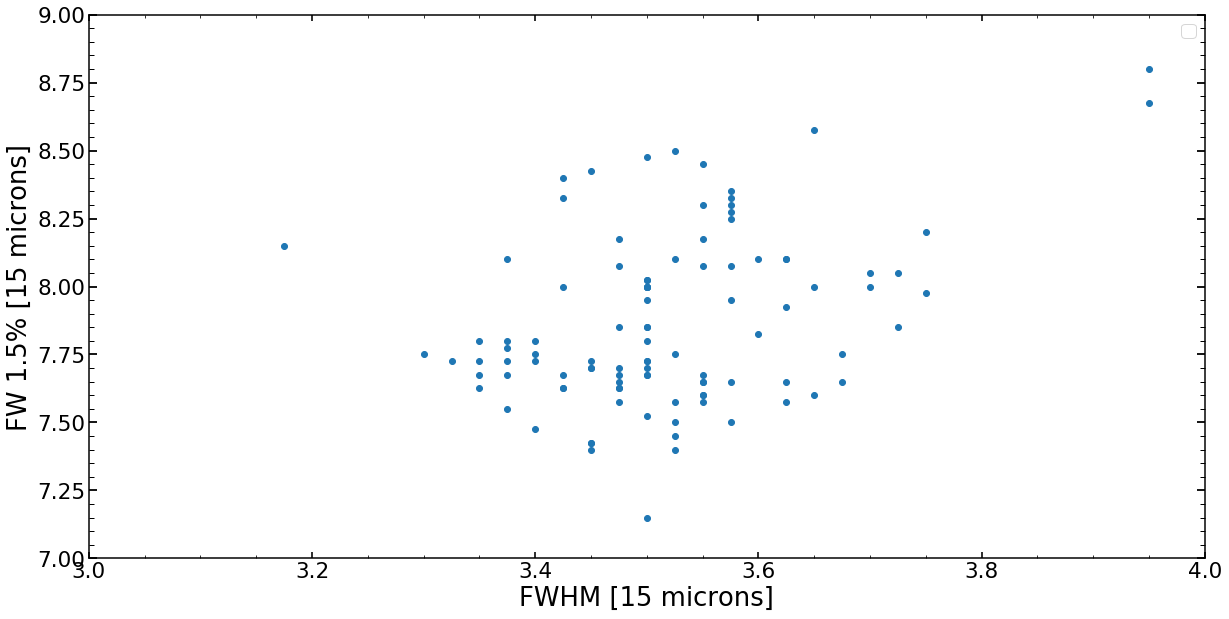

In [196]:
plt.figure(figsize=(20,10))

plt.scatter(array_of_FWHM_and_1_value[:,1],array_of_FWHM_and_1_value[:,2])

plt.xlabel('FWHM [15 microns]')
plt.ylabel('FW 1.5% [15 microns]' )
plt.legend()

plt.ylim(7,9)
plt.xlim(3,4)

### HgAr 

In [174]:
single_number=2
sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [180]:
FWHM_and_1_values_results

[217.5, 3.625, 8.35, 145, 290, 55, 390]

centered coordinate is [10.  5.]
FWHM positions in upsampled:[145, 290]
1.5% positions in upsampled:[55, 390]


(0, 0.02)

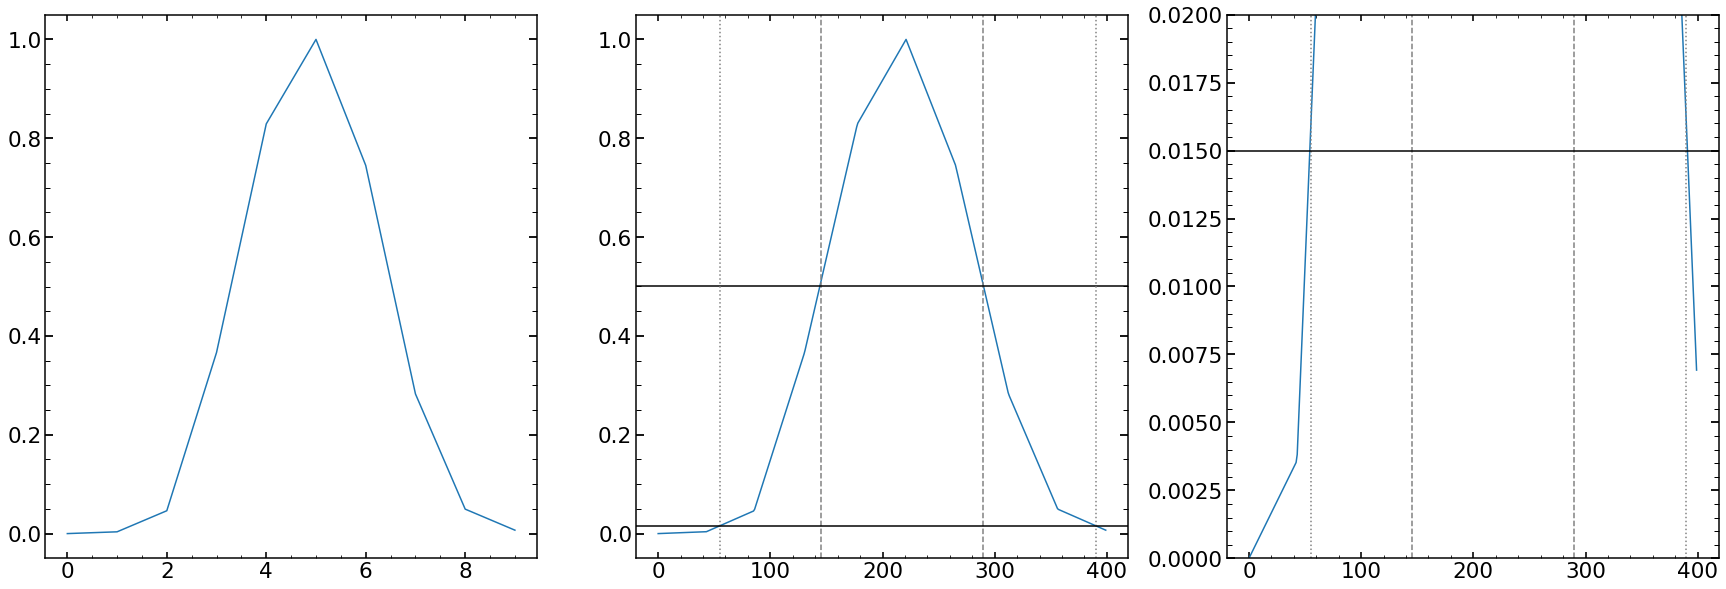

In [182]:
LSF=generate_1d(sci_image)
#plt.plot(LSF)
LSF_upsampled=upsample_coords([range(len(LSF)),LSF])
FWHM_and_1_values_results=find_FWHM_and_1_values(LSF)

plt.figure(figsize=(30,10))

plt.subplot(131)
plt.plot(LSF)

plt.subplot(132)
plt.plot(LSF_upsampled[1])
plt.axvline(FWHM_and_1_values_results[3],color='gray',ls='--')
plt.axvline(FWHM_and_1_values_results[4],color='gray',ls='--')
plt.axhline(0.5,color='black')


plt.axvline(FWHM_and_1_values_results[5],color='gray',ls=':')
plt.axvline(FWHM_and_1_values_results[6],color='gray',ls=':')
plt.axhline(0.015,color='black')


plt.subplot(133)
plt.plot(LSF_upsampled[1])
plt.axvline(FWHM_and_1_values_results[3],color='gray',ls='--')
plt.axvline(FWHM_and_1_values_results[4],color='gray',ls='--')

plt.axvline(FWHM_and_1_values_results[5],color='gray',ls=':')
plt.axvline(FWHM_and_1_values_results[6],color='gray',ls=':')

plt.axhline(0.015,color='black')

plt.ylim(0,0.02)

In [176]:
extraction_image=np.zeros((20,20))
rounded_center=np.round([find_centroid_of_flux(sci_image)])[0]
extraction_image[int(rounded_center[1])-5:int(rounded_center[1])+5,int(rounded_center[0])-3:int(rounded_center[0])+3]=1

In [177]:
rounded_center

array([10.,  5.])

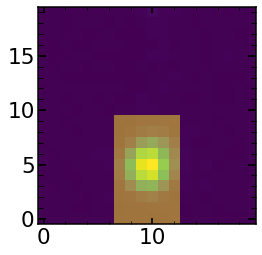

In [178]:
plt.imshow(sci_image)
plt.imshow(extraction_image,alpha=0.5)

In [ ]:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
        mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
        var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

        if np.sum(mask_image)==0:



            LSF=generate_1d(sci_image)
            FWHM_and_1_value=find_FWHM_and_1_values(LSF)

In [336]:
np.setdiff1d(np.arange(120),Zernike_info_df_Ar_021604[Zernike_info_df_Ar_021604['wavelength']=='690.9346'].index.values)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119])

In [334]:
Zernike_info_df_Ar_021604[Zernike_info_df_Ar_021604['wavelength']=='690.9346'].index.values

array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108])

In [337]:
single_number=0
STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/" 
arc='HgAr'
obs=21346+54
sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

list_of_FWHM_and_1_value_HgAr=[]
#exclude the Hg line at 690
for single_number in np.setdiff1d(np.arange(120),Zernike_info_df_Ar_021604[Zernike_info_df_Ar_021604['wavelength']=='690.9346'].index.values):
    print('single_number '+str(single_number))
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
        mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
        var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

        if np.sum(mask_image)==0:



            LSF=generate_1d(sci_image)
            FWHM_and_1_value=find_FWHM_and_1_values(LSF)
            list_of_FWHM_and_1_value_HgAr.append([single_number,FWHM_and_1_value[1],FWHM_and_1_value[2]])
        else:
            pass
    except:
        pass
 
# index, FWHM value, 1% value
array_of_FWHM_and_1_value_HgAr=np.array(list_of_FWHM_and_1_value_HgAr)

single_number 1
centered coordinate is [9. 8.]
FWHM positions in upsampled:[146, 291]
1.5% positions in upsampled:[55, 392]
single_number 2
centered coordinate is [10.  5.]
FWHM positions in upsampled:[145, 290]
1.5% positions in upsampled:[55, 390]
single_number 3
centered coordinate is [9. 8.]
FWHM positions in upsampled:[123, 274]
1.5% positions in upsampled:[45, 355]
single_number 4
centered coordinate is [10. 14.]
FWHM positions in upsampled:[162, 299]
1.5% positions in upsampled:[87, 397]
single_number 5
centered coordinate is [10.  9.]
FWHM positions in upsampled:[154, 298]
1.5% positions in upsampled:[82, 389]
single_number 6
centered coordinate is [8. 7.]
FWHM positions in upsampled:[138, 283]
1.5% positions in upsampled:[54, 358]
single_number 7
centered coordinate is [11.  9.]
FWHM positions in upsampled:[150, 297]
1.5% positions in upsampled:[48, 396]
single_number 8
centered coordinate is [8. 9.]
FWHM positions in upsampled:[150, 298]
1.5% positions in upsampled:[45, 399]


single_number 109
centered coordinate is [9. 9.]
FWHM positions in upsampled:[143, 288]
1.5% positions in upsampled:[54, 389]
single_number 110
centered coordinate is [8. 5.]
FWHM positions in upsampled:[142, 286]
1.5% positions in upsampled:[53, 391]
single_number 111
centered coordinate is [ 7. 10.]
FWHM positions in upsampled:[163, 299]
1.5% positions in upsampled:[87, 397]
single_number 112
centered coordinate is [10. 13.]
FWHM positions in upsampled:[159, 299]
1.5% positions in upsampled:[86, 393]
single_number 113
centered coordinate is [10.  9.]
FWHM positions in upsampled:[151, 291]
1.5% positions in upsampled:[76, 381]
single_number 114
centered coordinate is [11.  7.]
FWHM positions in upsampled:[131, 277]
1.5% positions in upsampled:[51, 355]
single_number 115
centered coordinate is [ 8. 10.]
FWHM positions in upsampled:[144, 292]
1.5% positions in upsampled:[46, 393]
single_number 116
centered coordinate is [ 9. 10.]
FWHM positions in upsampled:[144, 292]
1.5% positions in 

In [223]:
list_of_FWHM_and_1_value_HgAr

[[0, 3.925, 8.4],
 [1, 3.625, 8.375],
 [2, 3.625, 8.35],
 [3, 3.775, 7.75],
 [4, 3.425, 7.75],
 [5, 3.6, 7.675],
 [6, 3.625, 7.6],
 [7, 3.675, 8.65],
 [8, 3.7, 8.675],
 [9, 3.675, 8.45],
 [10, 4.025, 9.0],
 [11, 3.925, 8.825],
 [12, 3.7, 8.3],
 [13, 3.5, 8.05],
 [14, 3.625, 8.0],
 [15, 3.575, 7.625],
 [16, 3.5, 7.575],
 [17, 3.5, 7.575],
 [18, 3.5, 7.375],
 [19, 3.725, 8.425],
 [20, 3.65, 8.6],
 [21, 3.75, 7.775],
 [22, 3.825, 8.8],
 [23, 3.9, 8.85],
 [24, 3.575, 8.325],
 [25, 3.475, 7.775],
 [26, 3.3, 7.75],
 [27, 3.475, 7.95],
 [28, 3.425, 7.65],
 [29, 3.5, 7.65],
 [30, 3.525, 7.575],
 [31, 3.575, 8.55],
 [32, 3.65, 8.625],
 [33, 3.45, 7.925],
 [34, 3.625, 8.6],
 [35, 3.4, 8.375],
 [36, 3.55, 8.225],
 [37, 3.5, 7.575],
 [38, 3.325, 7.75],
 [39, 3.575, 7.9],
 [40, 3.525, 7.85],
 [41, 3.475, 7.575],
 [42, 3.475, 7.55],
 [43, 3.7, 8.5],
 [44, 3.575, 8.55],
 [45, 3.775, 7.7],
 [46, 3.6, 8.575],
 [47, 3.475, 8.45],
 [48, 3.45, 8.125],
 [49, 3.425, 7.675],
 [50, 3.65, 7.7],
 [51, 3.625, 7.

### comparing 

In [338]:
arc='HgAr'
visit_0='021604'
Zernike_info_df_HgAr_021604=np.load(DATA_FOLDER_FOR_poststamps+'Dataframes/Zernike_info_df_'+arc+'_'+visit_0,allow_pickle=True)

broad_index=np.concatenate((Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='826.6699'].index,\
                           Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='852.4029'].index,\
                          Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='922.7301'].index))

array_of_FWHM_and_1_value_HgAr_broad=[]
array_of_FWHM_and_1_value_HgAr_not_broad=[]
for i in array_of_FWHM_and_1_value_HgAr[:,0]:
    if i in broad_index:
        index_in_array=np.where(array_of_FWHM_and_1_value_HgAr[:,0]==i)[0][0]
        array_of_FWHM_and_1_value_HgAr_broad.append(array_of_FWHM_and_1_value_HgAr[index_in_array])
    else:
        index_in_array=np.where(array_of_FWHM_and_1_value_HgAr[:,0]==i)[0][0]
        array_of_FWHM_and_1_value_HgAr_not_broad.append(array_of_FWHM_and_1_value_HgAr[index_in_array])
        
array_of_FWHM_and_1_value_Ar_broad=[]
array_of_FWHM_and_1_value_Ar_not_broad=[]
for i in array_of_FWHM_and_1_value_Ar[:,0]:
    if i in broad_index:
        index_in_array=np.where(array_of_FWHM_and_1_value_Ar[:,0]==i)[0][0]
        array_of_FWHM_and_1_value_Ar_broad.append(array_of_FWHM_and_1_value_Ar[index_in_array])
    else:
        index_in_array=np.where(array_of_FWHM_and_1_value_Ar[:,0]==i)[0][0]
        array_of_FWHM_and_1_value_Ar_not_broad.append(array_of_FWHM_and_1_value_Ar[index_in_array])
        
 
array_of_FWHM_and_1_value_Ar_not_broad=np.array(array_of_FWHM_and_1_value_Ar_not_broad)
array_of_FWHM_and_1_value_Ar_broad=np.array(array_of_FWHM_and_1_value_Ar_broad)
array_of_FWHM_and_1_value_HgAr_not_broad=np.array(array_of_FWHM_and_1_value_HgAr_not_broad)
array_of_FWHM_and_1_value_HgAr_broad=np.array(array_of_FWHM_and_1_value_HgAr_broad)

In [339]:
np.where(array_of_FWHM_and_1_value_Ar[:,0]==55)[0][0]

50

No handles with labels found to put in legend.


(3, 4)

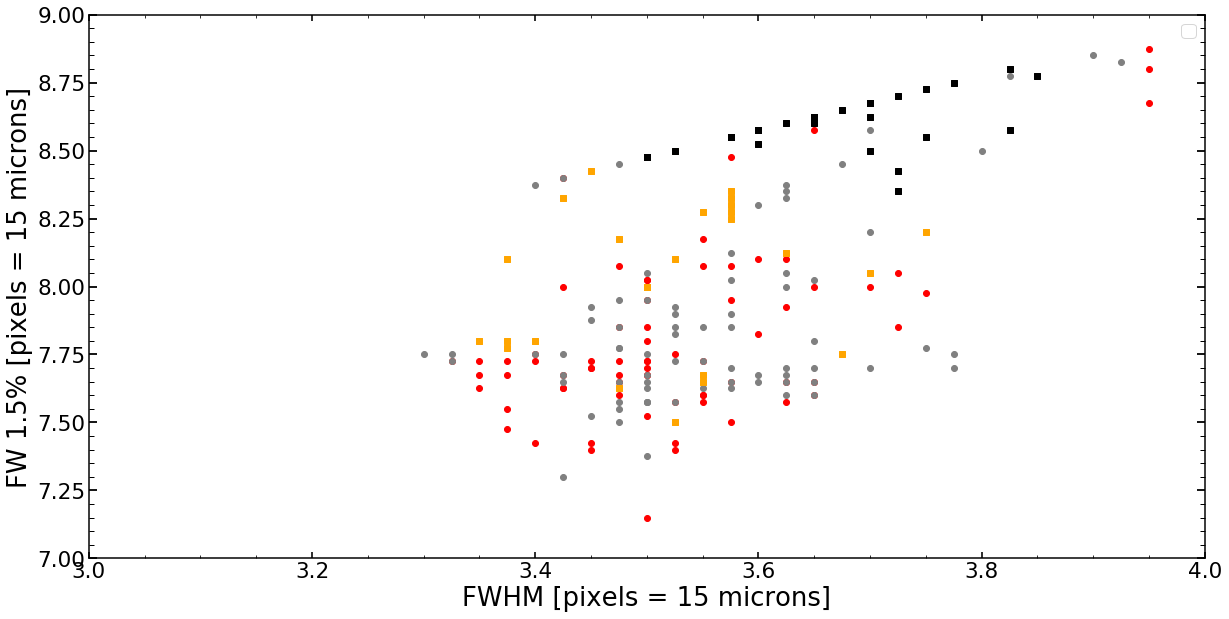

In [340]:
plt.figure(figsize=(20,10))

plt.scatter(array_of_FWHM_and_1_value_Ar_not_broad[:,1],array_of_FWHM_and_1_value_Ar_not_broad[:,2],color='red',marker='o')
plt.scatter(array_of_FWHM_and_1_value_HgAr_not_broad[:,1],array_of_FWHM_and_1_value_HgAr_not_broad[:,2],color='gray',marker='o')

plt.scatter(array_of_FWHM_and_1_value_Ar_broad[:,1],array_of_FWHM_and_1_value_Ar_broad[:,2],color='orange',marker='s')
plt.scatter(array_of_FWHM_and_1_value_HgAr_broad[:,1],array_of_FWHM_and_1_value_HgAr_broad[:,2],color='black',marker='s')

plt.xlabel('FWHM [pixels = 15 microns]')
plt.ylabel('FW 1.5% [pixels = 15 microns]' )
plt.legend()


plt.ylim(7,9)
plt.xlim(3,4)

In [341]:
Ar_broad_quantiles=[np.quantile(array_of_FWHM_and_1_value_Ar_broad[:,1],[0.16,0.5,0.84]),np.quantile(array_of_FWHM_and_1_value_Ar_broad[:,2],[0.16,0.5,0.84])]
Ar_not_broad_quantiles=[np.quantile(array_of_FWHM_and_1_value_Ar_not_broad[:,1],[0.16,0.5,0.84]),np.quantile(array_of_FWHM_and_1_value_Ar_not_broad[:,2],[0.16,0.5,0.84])]
HgAr_broad_quantiles=[np.quantile(array_of_FWHM_and_1_value_HgAr_broad[:,1],[0.16,0.5,0.84]),np.quantile(array_of_FWHM_and_1_value_HgAr_broad[:,2],[0.16,0.5,0.84])]
HgAr_not_broad_quantiles=[np.quantile(array_of_FWHM_and_1_value_HgAr_not_broad[:,1],[0.16,0.5,0.84]),np.quantile(array_of_FWHM_and_1_value_HgAr_not_broad[:,2],[0.16,0.5,0.84])]

In [342]:
x_values=[Ar_broad_quantiles[0][1],Ar_not_broad_quantiles[0][1],HgAr_broad_quantiles[0][1],HgAr_not_broad_quantiles[0][1]]
y_values=[Ar_broad_quantiles[1][1],Ar_not_broad_quantiles[1][1],HgAr_broad_quantiles[1][1],HgAr_not_broad_quantiles[1][1]]

xerr_values=np.transpose(np.array([[Ar_broad_quantiles[0][1]-Ar_broad_quantiles[0][0],Ar_broad_quantiles[0][2]-Ar_broad_quantiles[0][1]],\
             [Ar_not_broad_quantiles[0][1]-Ar_not_broad_quantiles[0][0],Ar_not_broad_quantiles[0][2]-Ar_not_broad_quantiles[0][1]],\
             [HgAr_broad_quantiles[0][1]-HgAr_broad_quantiles[0][0],HgAr_broad_quantiles[0][2]-HgAr_broad_quantiles[0][1]],\
             [HgAr_not_broad_quantiles[0][1]-HgAr_not_broad_quantiles[0][0],HgAr_not_broad_quantiles[0][2]-HgAr_not_broad_quantiles[0][1]]]))

yerr_values=np.transpose(np.array([[Ar_broad_quantiles[1][1]-Ar_broad_quantiles[1][0],Ar_broad_quantiles[1][2]-Ar_broad_quantiles[1][1]],\
             [Ar_not_broad_quantiles[1][1]-Ar_not_broad_quantiles[1][0],Ar_not_broad_quantiles[1][2]-Ar_not_broad_quantiles[1][1]],\
             [HgAr_broad_quantiles[1][1]-HgAr_broad_quantiles[1][0],HgAr_broad_quantiles[1][2]-HgAr_broad_quantiles[1][1]],\
             [HgAr_not_broad_quantiles[1][1]-HgAr_not_broad_quantiles[1][0],HgAr_not_broad_quantiles[1][2]-HgAr_not_broad_quantiles[1][1]]]))

xerr_values.shape

(2, 4)

In [343]:
x_values

[3.525, 3.5, 3.6624999999999996, 3.5374999999999996]

In [344]:
y_values

[8.075, 7.7125, 8.6, 7.75]

Text(0.5, 1.0, 'Width of Argon lines from pure Argon lamp and HgAr lamp')

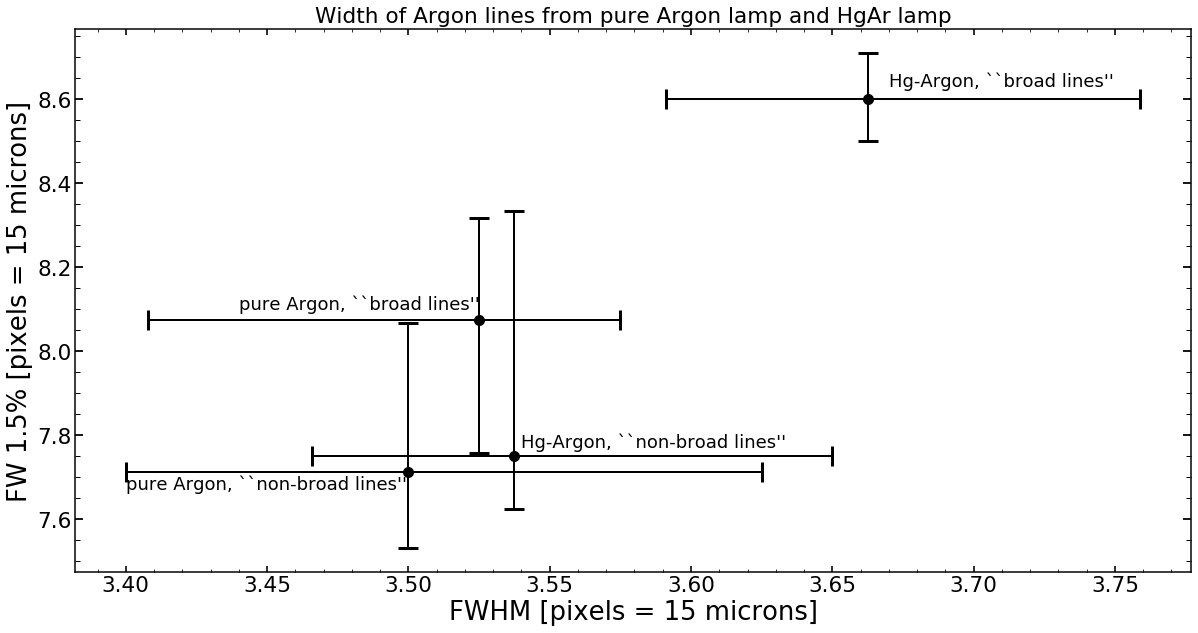

In [360]:
plt.figure(figsize=(20,10))
plt.errorbar(x=x_values,y=y_values,xerr=xerr_values,yerr=yerr_values,ls='',marker='o',capsize=10,capthick=3,color='black',elinewidth=2,markersize=10)
plt.text(3.440,8.1,s='pure Argon, ``broad lines\'\'' )
plt.text(3.40,7.672,s='pure Argon, ``non-broad lines\'\'')
plt.text(3.67,8.63,s='Hg-Argon, ``broad lines\'\'')
plt.text(3.54,7.77,s='Hg-Argon, ``non-broad lines\'\'')

plt.xlabel('FWHM [pixels = 15 microns]')
plt.ylabel('FW 1.5% [pixels = 15 microns]' )

plt.title('Width of Argon lines from pure Argon lamp and HgAr lamp')

In [261]:
np.array([Ar_broad_quantiles[0][1]-Ar_broad_quantiles[0][0],Ar_broad_quantiles[0][2]-Ar_broad_quantiles[0][1]])

array([0.117, 0.05 ])

In [243]:
np.quantile(array_of_FWHM_and_1_value_Ar_broad[:,1],[0.16,0.5,0.84])

array([3.408, 3.525, 3.575])

In [218]:
broad_index=np.concatenate((Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='826.6699'].index,\
                           Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='852.4029'].index,\
                          Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='922.7301'].index))

broad_index

array([  7,  19,  31,  43,  55,  67,  79,  91, 103, 115,   8,  20,  32,
        44,  56,  68,  80,  92, 104, 116,  10,  22,  34,  46,  58,  70,
        82,  94, 106, 118])

In [210]:
Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='826.6699'].index

Int64Index([7, 19, 31, 43, 55, 67, 79, 91, 103, 115], dtype='int64')

In [214]:
Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='852.4029'].index

Int64Index([8, 20, 32, 44, 56, 68, 80, 92, 104, 116], dtype='int64')

In [215]:
Zernike_info_df_HgAr_021604[Zernike_info_df_HgAr_021604['wavelength']=='922.7301'].index

Int64Index([10, 22, 34, 46, 58, 70, 82, 94, 106, 118], dtype='int64')

# Cutting data for Brent 

# Quality through pipeline